In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

import pandas            as pd
import networkx          as nx
import matplotlib.pyplot as plt
import seaborn           as sns
import numpy             as np

from prettytable           import PrettyTable
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from utils  import construct_prop_df, construct_graph, remove_corr, log_transform
from config import PATH, THRESHOLDS, RT_UNDER_COLUMNS, EXCLUDE_COLUMNS

In [2]:
EXCLUDE_COLUMNS.append('tweet')

In [3]:
df_og    = pd.read_csv(PATH + 'dataset_enhanced.csv')
users_df = pd.read_csv(PATH + 'user_dataset.csv')

df = df_og.copy()

df = df.merge(users_df, left_on='poster', right_on='user_id', how='left')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2139 non-null   int64  
 1   tweet               2139 non-null   object 
 2   label               2139 non-null   object 
 3   poster              2139 non-null   int64  
 4   num_rt              2139 non-null   int64  
 5   depth_max           2139 non-null   int64  
 6   depth_avg           2139 non-null   float64
 7   time_total          2139 non-null   float64
 8   time_avg            2139 non-null   float64
 9   rts_half_life       2139 non-null   float64
 10  num_circles         2139 non-null   int64  
 11  rts_under_5_min     2139 non-null   int64  
 12  rts_under_30_min    2139 non-null   int64  
 13  rts_under_60_min    2139 non-null   int64  
 14  rts_under_180_min   2139 non-null   int64  
 15  rts_under_480_min   2139 non-null   int64  
 16  rts_un

In [11]:
df.describe()

tweet_id        poster       num_rt    depth_max    depth_avg  \
count  2.139000e+03  2.139000e+03  2139.000000  2139.000000  2139.000000   
mean   5.978334e+17  6.592889e+14   421.970079     3.710612     1.299997   
std    1.047311e+17  2.155623e+16   440.488233     1.592468     0.324892   
min    8.008068e+16  1.591300e+04    55.000000     1.000000     0.666667   
25%    5.249236e+17  5.741722e+06   156.000000     3.000000     1.082028   
50%    5.763198e+17  1.820835e+07   275.000000     3.000000     1.181452   
75%    6.923796e+17  1.370536e+08   490.500000     4.000000     1.408280   
max    7.808825e+17  7.094974e+17  3125.000000    16.000000     5.076190   

         time_total      time_avg  rts_half_life  num_circles  \
count  2.139000e+03  2.139000e+03    2139.000000  2139.000000   
mean   6.993504e+04  2.938918e+03       0.977390     2.243572   
std    1.650022e+05  5.234127e+04       0.073657     6.450578   
min    5.238000e+01  6.423898e+00       0.000000     0.000000   
25%    4.117190e+03  1.457284e+02       0.982759     0.000000   
50%    1.170703e+04  3.269286e+02       0.992000     0.000000   
75%    5.055951e+04  8.284055e+02       0.996283     2.000000   
max    2.675421e+06  2.373111e+06       0.999607    84.000000   

       rts_under_5_min  ...     num_urls  num_mentions  num_hashtags  \
count      2139.000000  ...  2139.000000   2139.000000   2139.000000   
mean         58.585320  ...     1.301543      0.192613      0.416550   
std          84.588541  ...     0.679963      0.534429      0.777325   
min           0.000000  ...     0.000000      0.000000      0.000000   
25%          15.000000  ...     1.000000      0.000000      0.000000   
50%          38.000000  ...     1.000000      0.000000      0.000000   
75%          73.000000  ...     2.000000      0.000000      1.000000   
max        1850.000000  ...     3.000000      5.000000      7.000000   

         num_emoji     num_punc   day_1_perc  user_id  user_rt  num_post  \
count  2139.000000  2139.000000  2139.000000      0.0      0.0       0.0   
mean      0.068256     2.552595     0.918421      NaN      NaN       NaN   
std       1.034493     1.998460     0.150968      NaN      NaN       NaN   
min       0.000000     0.000000     0.000000      NaN      NaN       NaN   
25%       0.000000     1.000000     0.920708      NaN      NaN       NaN   
50%       0.000000     2.000000     0.966292      NaN      NaN       NaN   
75%       0.000000     4.000000     0.988610      NaN      NaN       NaN   
max      45.000000    12.000000     1.000000      NaN      NaN       NaN   

       user_time_rt  
count           0.0  
mean            NaN  
std             NaN  
min             NaN  
25%             NaN  
50%             NaN  
75%             NaN  
max             NaN  

[8 rows x 28 columns]

In [14]:
def calc_median(df):
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)

    return df_filtered.median().round(2)
    
calc_median(df)

tweet_id              5.763198e+17
num_rt                2.750000e+02
depth_max             3.000000e+00
depth_avg             1.180000e+00
time_total            1.170703e+04
time_avg              3.269300e+02
rts_half_life         9.900000e-01
num_circles           0.000000e+00
rts_under_5_min       3.800000e+01
rts_under_30_min      1.080000e+02
rts_under_60_min      1.400000e+02
rts_under_180_min     1.910000e+02
rts_under_480_min     2.240000e+02
rts_under_720_min     2.380000e+02
rts_under_1440_min    2.550000e+02
length                9.400000e+01
num_words             1.500000e+01
num_urls              1.000000e+00
num_mentions          0.000000e+00
num_hashtags          0.000000e+00
num_emoji             0.000000e+00
num_punc              2.000000e+00
day_1_perc            9.700000e-01
user_id                        NaN
user_rt                        NaN
num_post                       NaN
user_time_rt                   NaN
dtype: float64

In [6]:
# remove all_caps count, all 0
df = df.drop(columns = ['num_all_caps'])

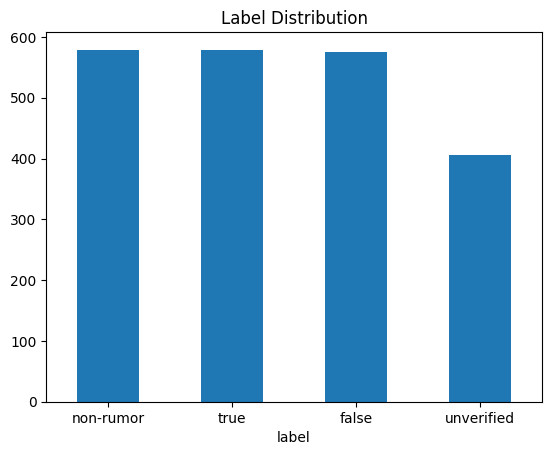

In [9]:
ax = df['label'].value_counts().plot(kind='bar', title="Label Distribution")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

In [8]:
# mapping and separation
label_mapping = {label: idx for idx, label in enumerate(sorted(set(df['label'])))}
print('Label Mapping')
print(label_mapping)
df['label'] = df['label'].map(label_mapping)

dfs    = []
titles = []
for t, l in label_mapping.items():
    dfs.append(df[df['label'] == l])
    titles.append(t)

Label Mapping
{'false': 0, 'non-rumor': 1, 'true': 2, 'unverified': 3}


In [9]:
stats_analysis_per_label(dfs, titles)

false                                 non-rumor  \
                            Mean           STD        Median          Mean   
tweet_id            5.503727e+17  9.616728e+16  5.389753e+17  7.015572e+17   
num_rt              3.649100e+02  4.438200e+02  2.140000e+02  6.292900e+02   
depth_max           3.680000e+00  1.650000e+00  3.000000e+00  3.800000e+00   
depth_avg           1.300000e+00  3.400000e-01  1.190000e+00  1.260000e+00   
time_total          1.015038e+05  2.338668e+05  1.220655e+04  6.137221e+04   
time_avg            7.890680e+03  1.005144e+05  4.468700e+02  8.120200e+02   
rts_half_life       9.700000e-01  9.000000e-02  9.900000e-01  9.900000e-01   
num_circles         6.090000e+00  1.168000e+01  2.000000e+00  4.450000e+00   
rts_under_5_min     3.633000e+01  5.472000e+01  2.300000e+01  9.300000e+01   
rts_under_30_min    1.099800e+02  1.420600e+02  7.700000e+01  2.469800e+02   
rts_under_60_min    1.464200e+02  1.805200e+02  1.010000e+02  3.143900e+02   
rts_under_180_min   2.108800e+02  2.479700e+02  1.390000e+02  4.228400e+02   
rts_under_480_min   2.648900e+02  3.179100e+02  1.690000e+02  5.079500e+02   
rts_under_720_min   2.826600e+02  3.371800e+02  1.790000e+02  5.388400e+02   
rts_under_1440_min  3.098700e+02  3.674500e+02  1.900000e+02  5.824300e+02   
length              8.825000e+01  2.460000e+01  9.100000e+01  8.968000e+01   
num_words           1.473000e+01  4.330000e+00  1.500000e+01  1.519000e+01   
num_urls            1.310000e+00  7.200000e-01  1.000000e+00  1.450000e+00   
num_mentions        2.000000e-01  5.700000e-01  0.000000e+00  2.700000e-01   
num_hashtags        4.100000e-01  7.800000e-01  0.000000e+00  2.600000e-01   
num_emoji           8.000000e-02  5.300000e-01  0.000000e+00  4.000000e-02   
num_punc            2.450000e+00  2.050000e+00  2.000000e+00  2.490000e+00   
day_1_perc          8.900000e-01  1.900000e-01  9.600000e-01  9.300000e-01   
user_id             4.003511e+08  7.251092e+08  5.311079e+07  1.142261e+07   
user_rt             2.610000e+00  5.320000e+00  1.000000e+00  5.550000e+00   
num_post            7.090000e+00  1.089000e+01  2.000000e+00  3.838000e+01   
user_time_rt        3.139800e+02  3.058870e+03  0.000000e+00  5.110000e+00   

                                                        true                \
                             STD        Median          Mean           STD   
tweet_id            2.841858e+16  6.928849e+17  5.229746e+17  6.450924e+16   
num_rt              4.462400e+02  4.780000e+02  3.600300e+02  4.155900e+02   
depth_max           1.540000e+00  3.000000e+00  3.670000e+00  1.580000e+00   
depth_avg           3.000000e-01  1.140000e+00  1.310000e+00  3.200000e-01   
time_total          8.446559e+04  2.157538e+04  6.553396e+04  1.725150e+05   
time_avg            2.016220e+03  3.819000e+02  1.139640e+03  5.398190e+03   
rts_half_life       4.000000e-02  1.000000e+00  9.800000e-01  8.000000e-02   
num_circles         7.770000e+00  2.000000e+00  3.540000e+00  8.180000e+00   
rts_under_5_min     9.025000e+01  7.200000e+01  6.715000e+01  1.084800e+02   
rts_under_30_min    2.061400e+02  1.970000e+02  1.668500e+02  2.063000e+02   
rts_under_60_min    2.505600e+02  2.510000e+02  2.084400e+02  2.442800e+02   
rts_under_180_min   3.154800e+02  3.340000e+02  2.696000e+02  3.028400e+02   
rts_under_480_min   3.667800e+02  3.970000e+02  3.075500e+02  3.430600e+02   
rts_under_720_min   3.856000e+02  4.200000e+02  3.199000e+02  3.593200e+02   
rts_under_1440_min  4.109300e+02  4.480000e+02  3.363200e+02  3.795900e+02   
length              2.340000e+01  9.300000e+01  9.371000e+01  2.253000e+01   
num_words           4.150000e+00  1.500000e+01  1.574000e+01  4.090000e+00   
num_urls            5.800000e-01  1.000000e+00  1.220000e+00  7.000000e-01   
num_mentions        6.200000e-01  0.000000e+00  1.000000e-01  3.600000e-01   
num_hashtags        5.100000e-01  0.000000e+00  4.800000e-01  8.500000e-01   
num_emoji           2.200000e-01  0.000000e+00  

In [10]:
def plot_avg_retweet_speed(dfs, titles):
    plt.figure(figsize=(12, 8))
    
    for df, t in zip(dfs, titles):
        average_retweets = df[RT_UNDER_COLUMNS].mean()
        plt.plot(THRESHOLDS[1:], average_retweets, label=t)
    
    plt.xlabel('Time (minutes)')
    plt.ylabel('AVG # Retweets')
    plt.title('Comparison of AVG Retweets Over Time - Day 1')
    plt.legend()
    plt.show()

    return None

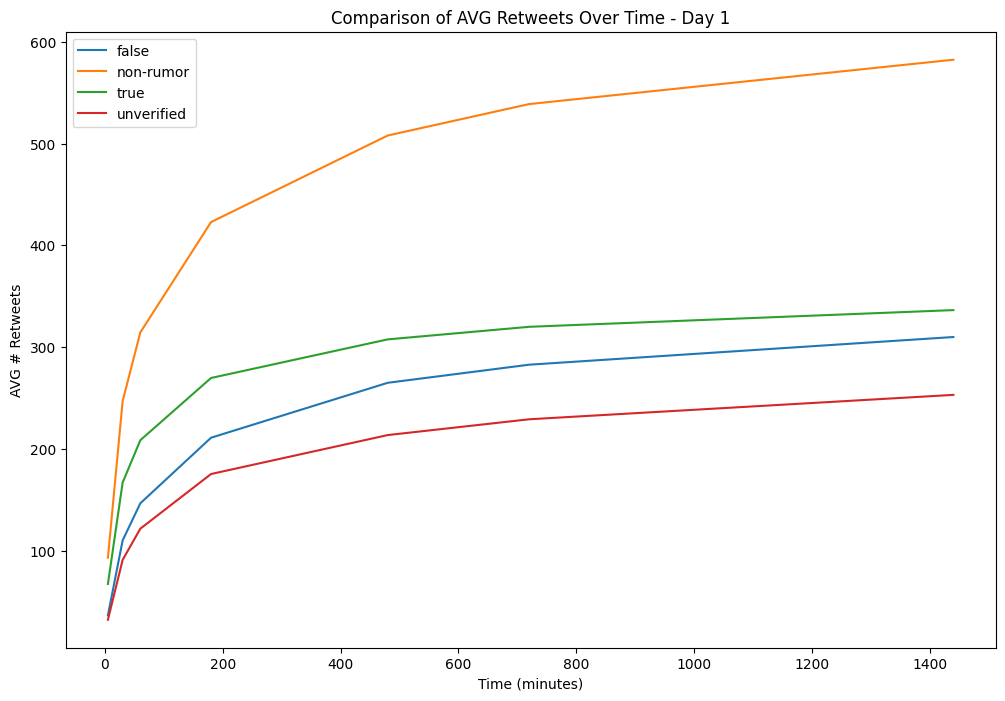

In [11]:
plot_avg_retweet_speed(dfs, titles)

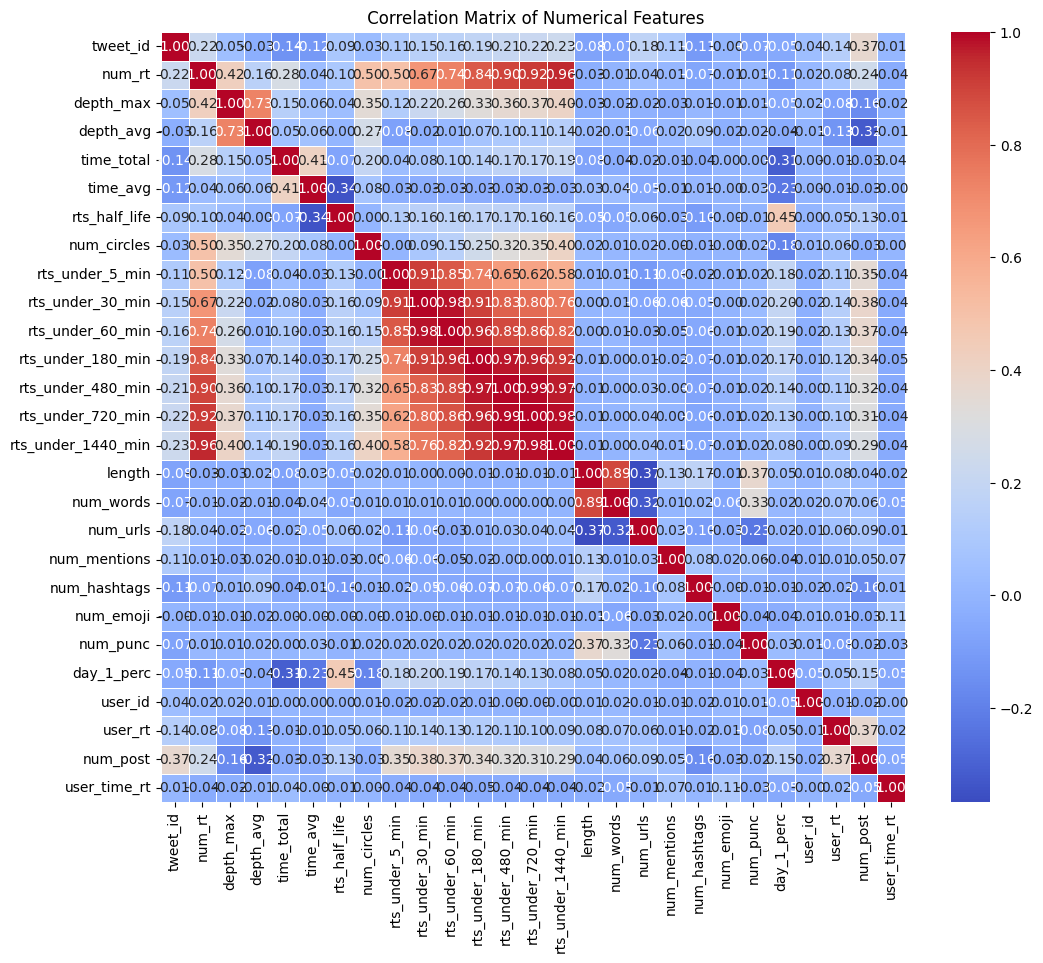

In [12]:
def correlation(df, title = ''):
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_filtered.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(f"{title} Correlation Matrix of Numerical Features")
    plt.show()

def correlation_per_label(dfs, titles):
    for dfi, t in zip(dfs, titles):
        correlation(dfi, t)
        
correlation(df)

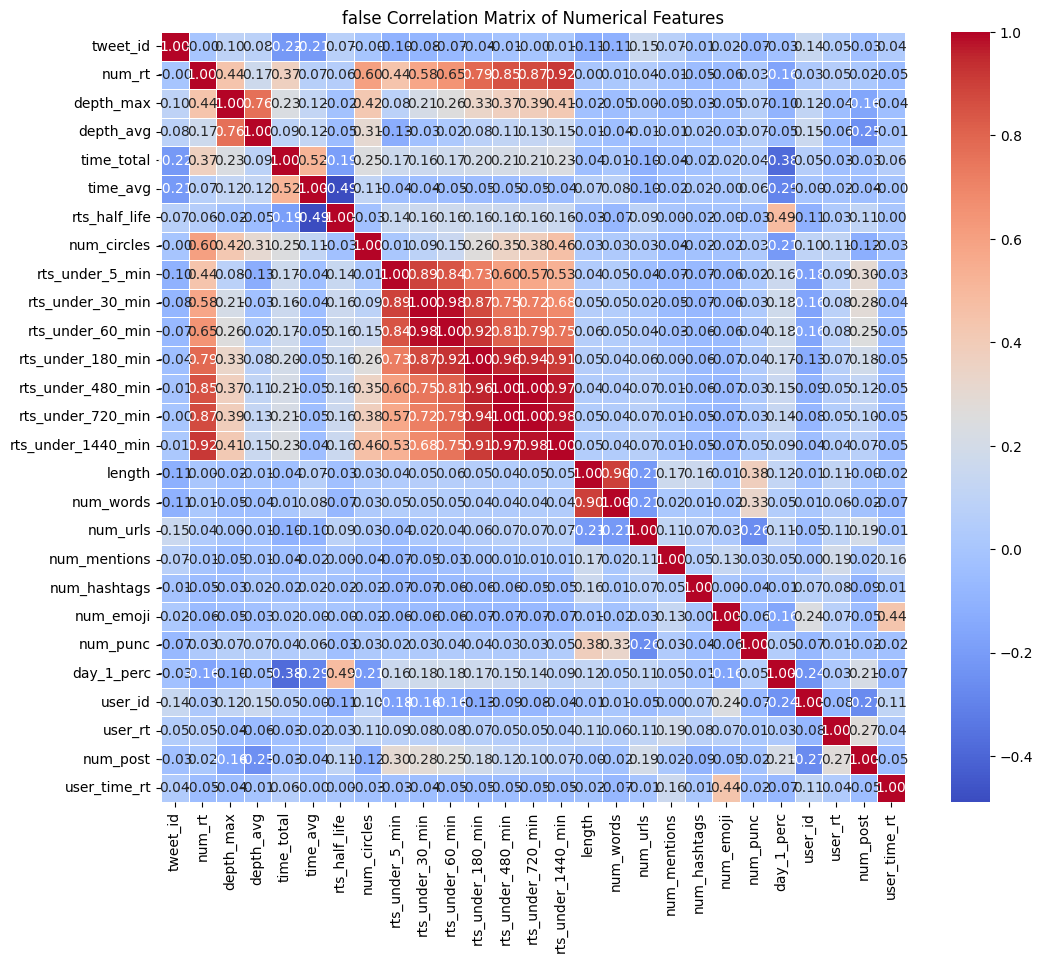

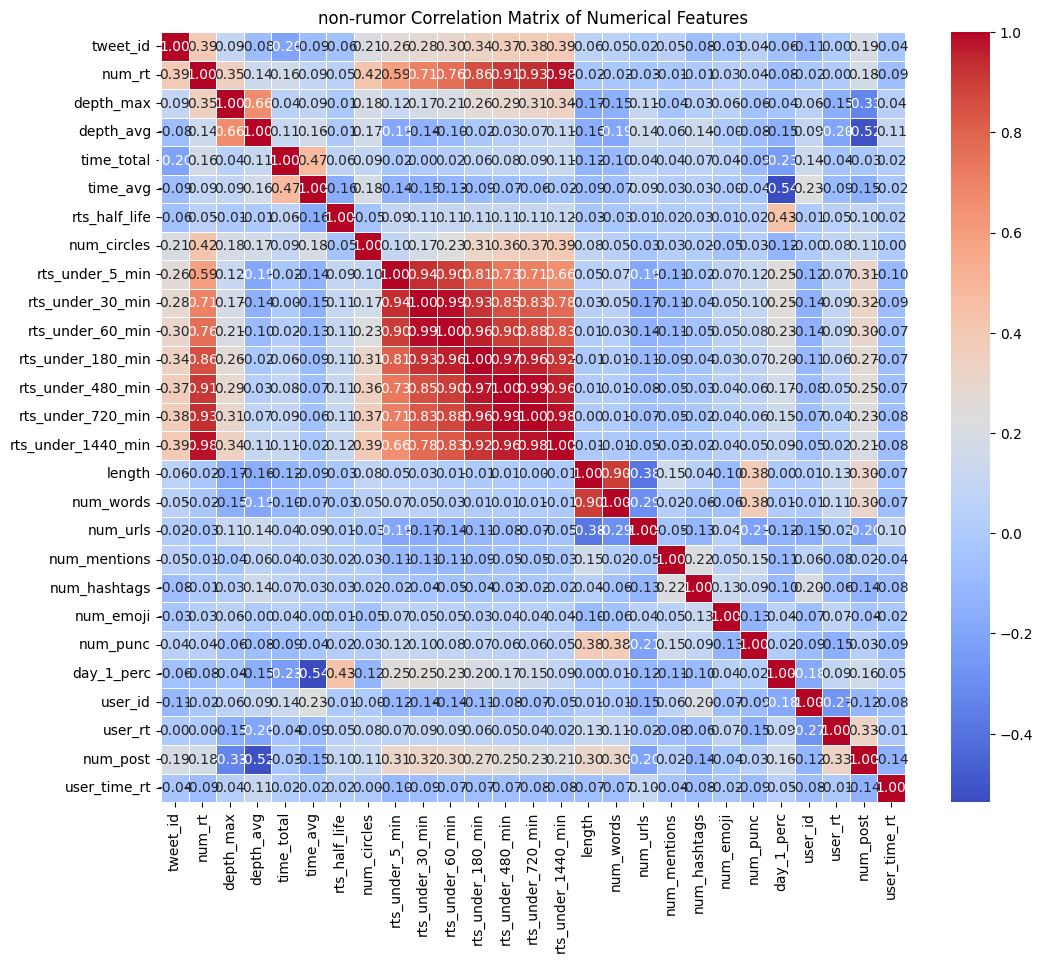

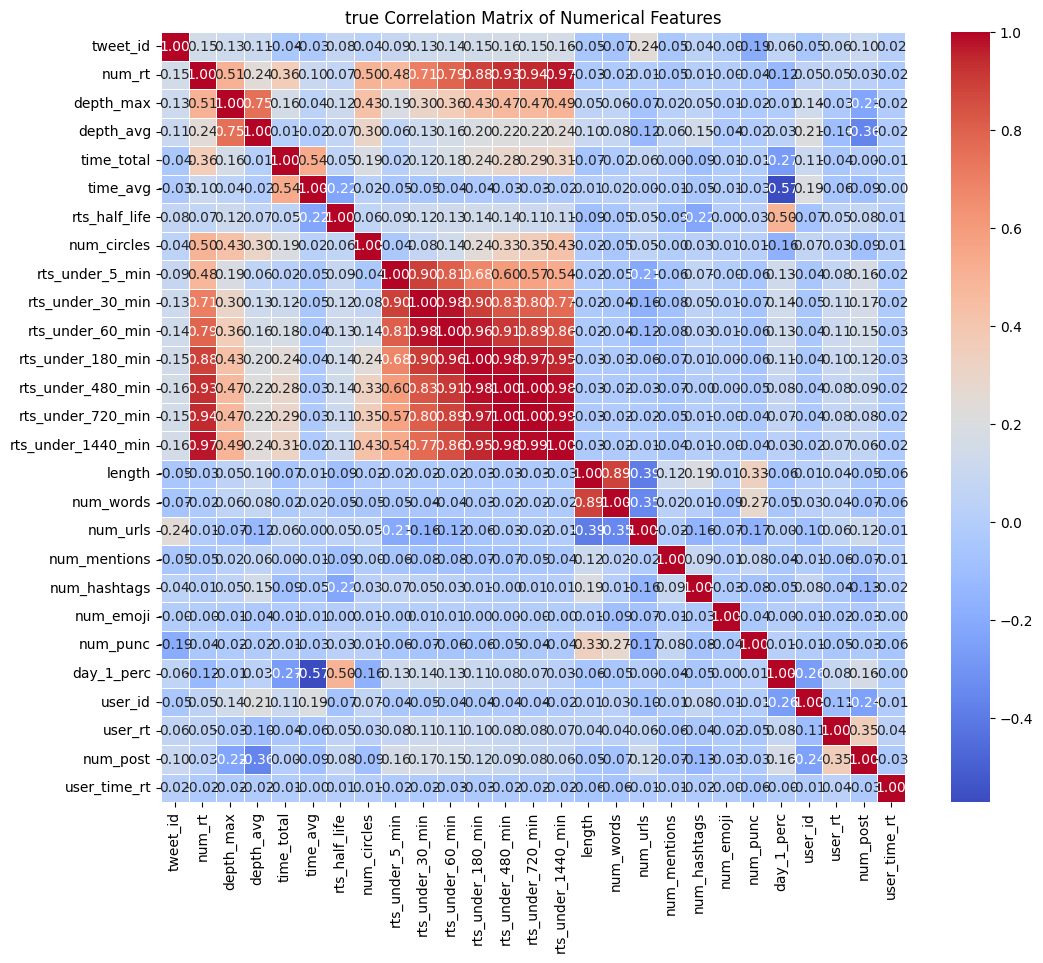

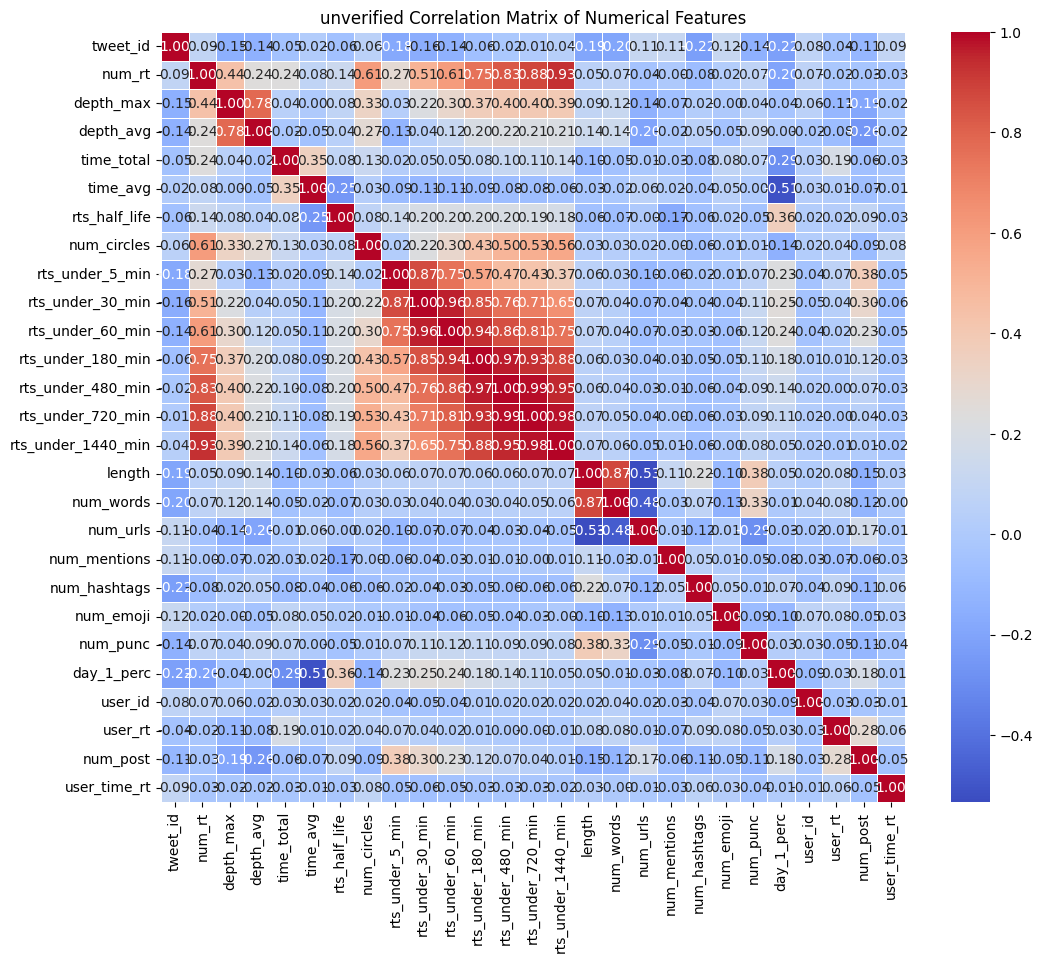

In [13]:
correlation_per_label(dfs, titles)

C:\Users\panos\AppData\Local\Temp\ipykernel_7896\81927494.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


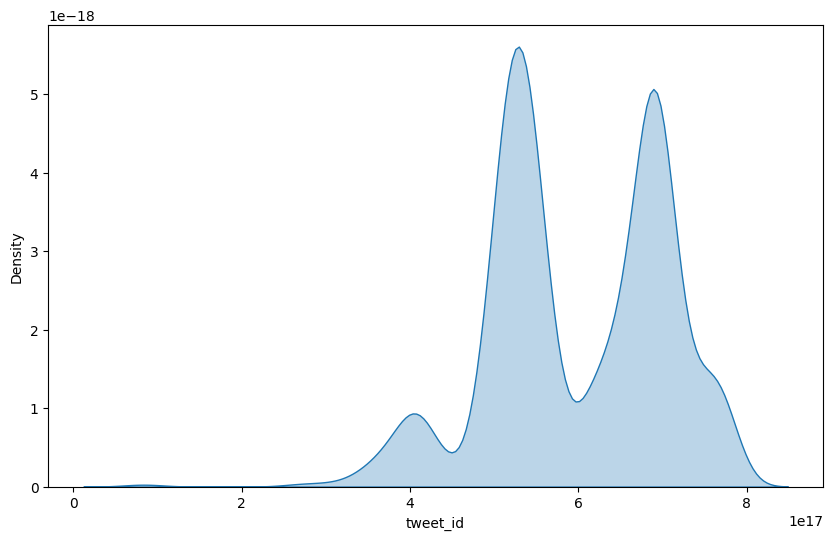

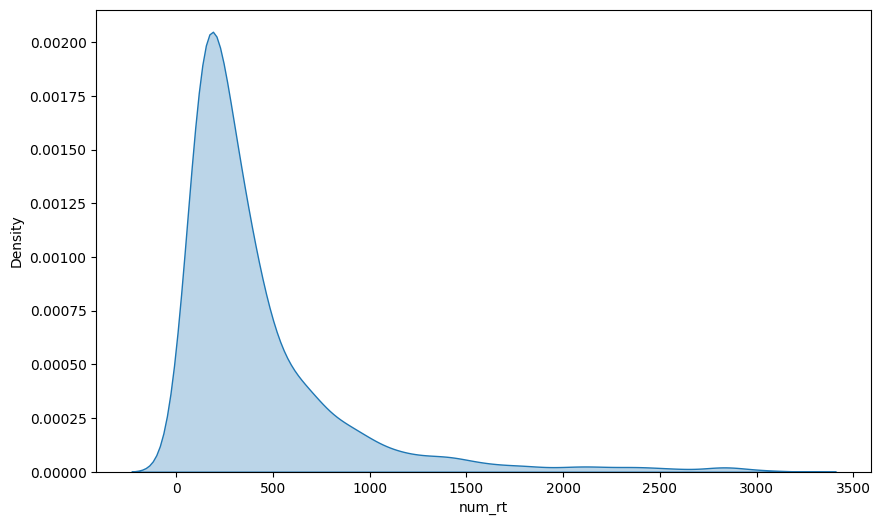

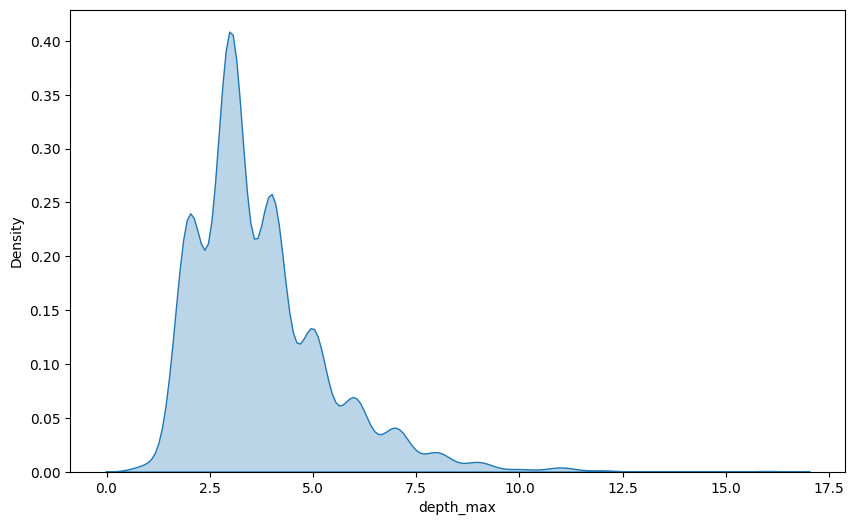

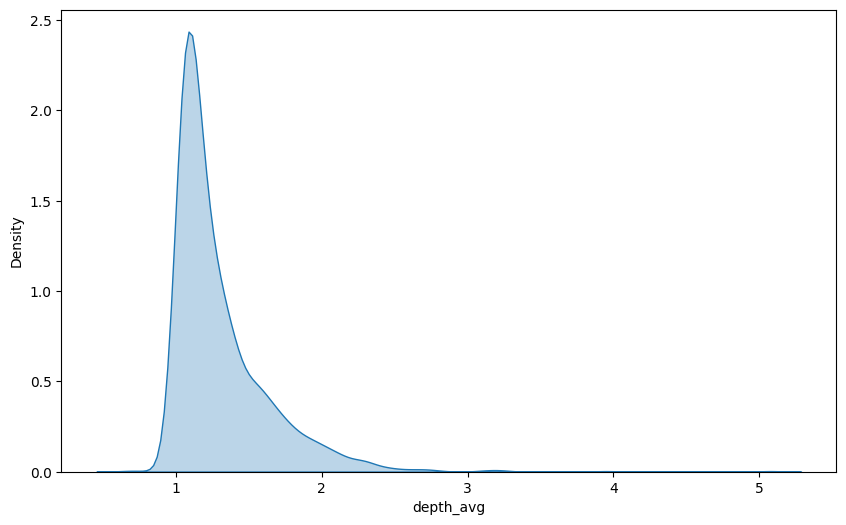

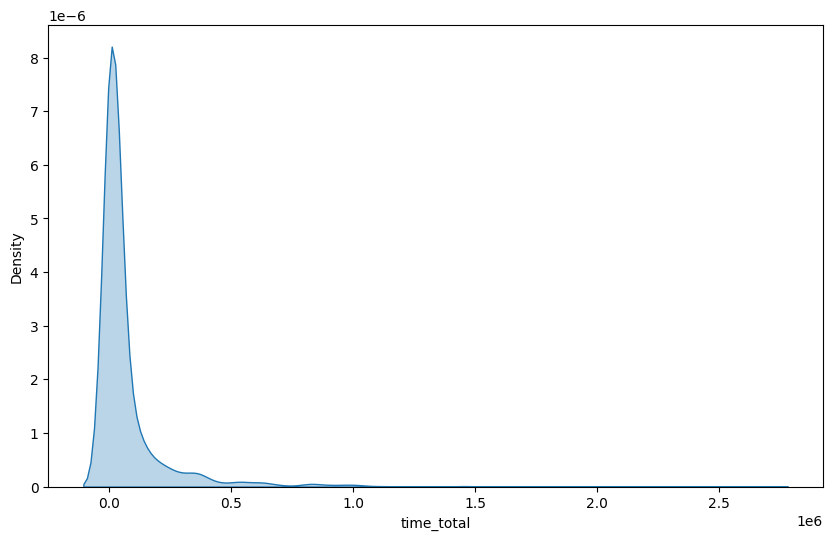

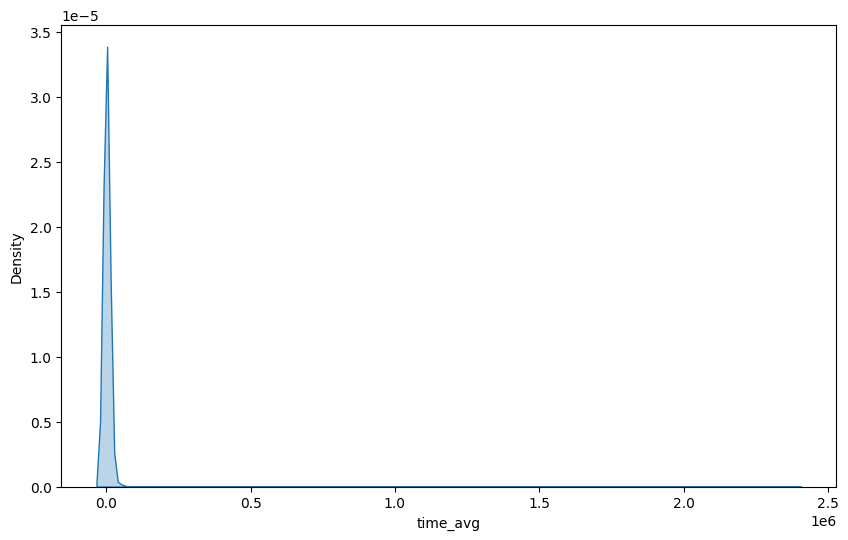

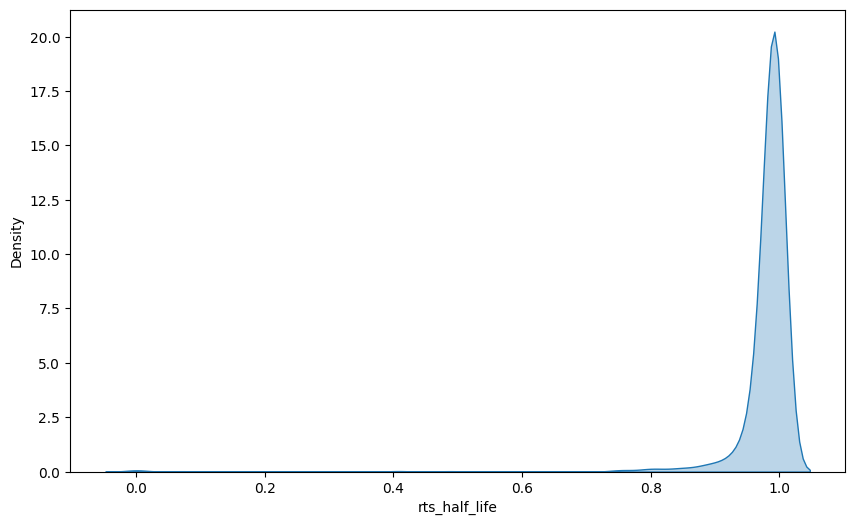

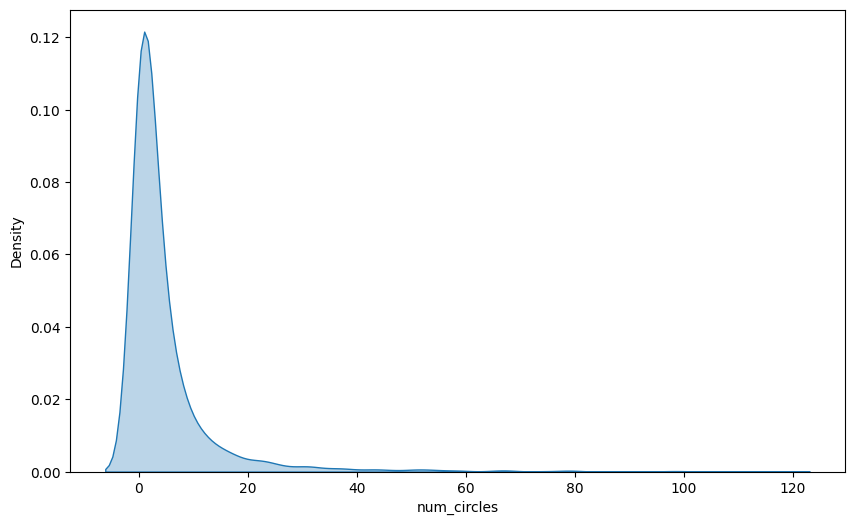

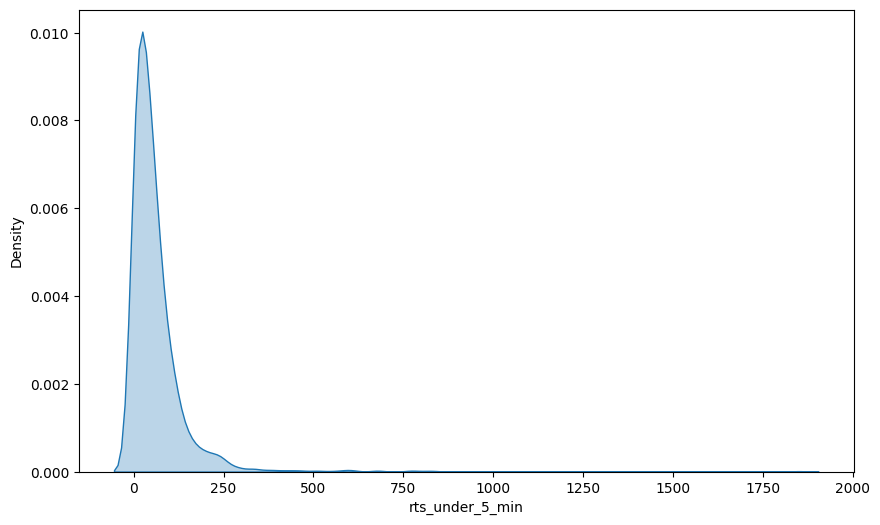

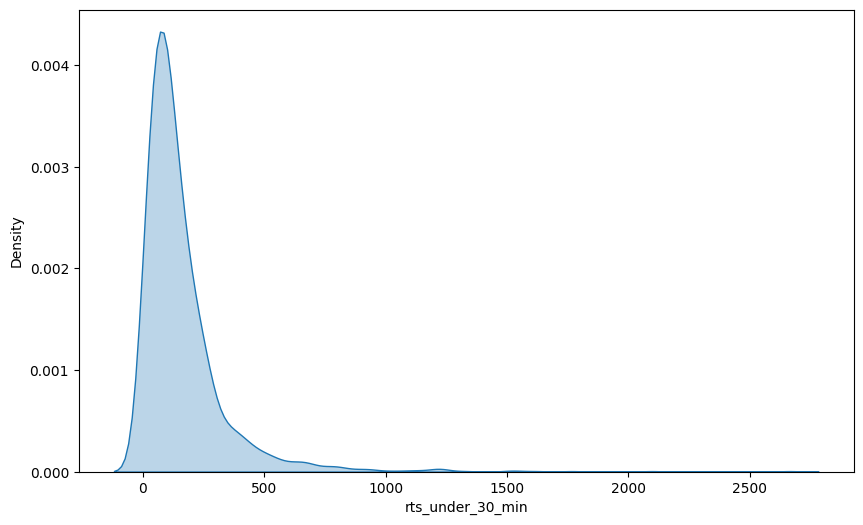

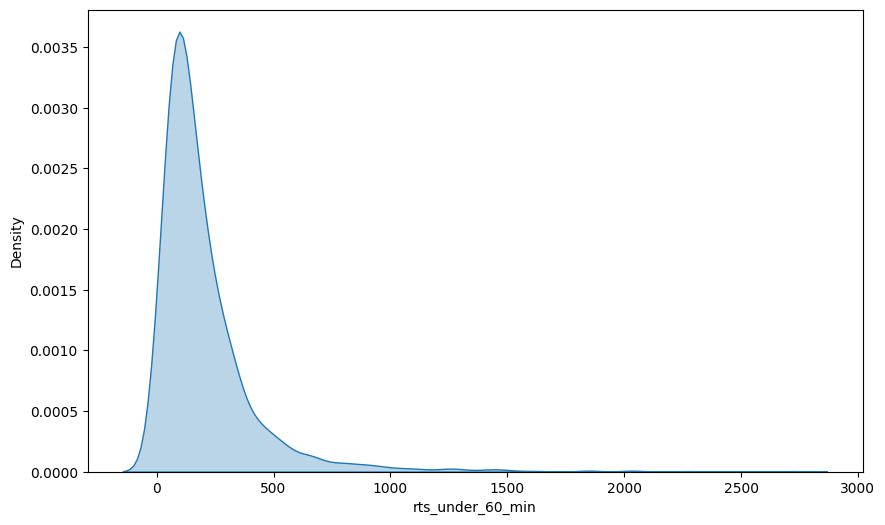

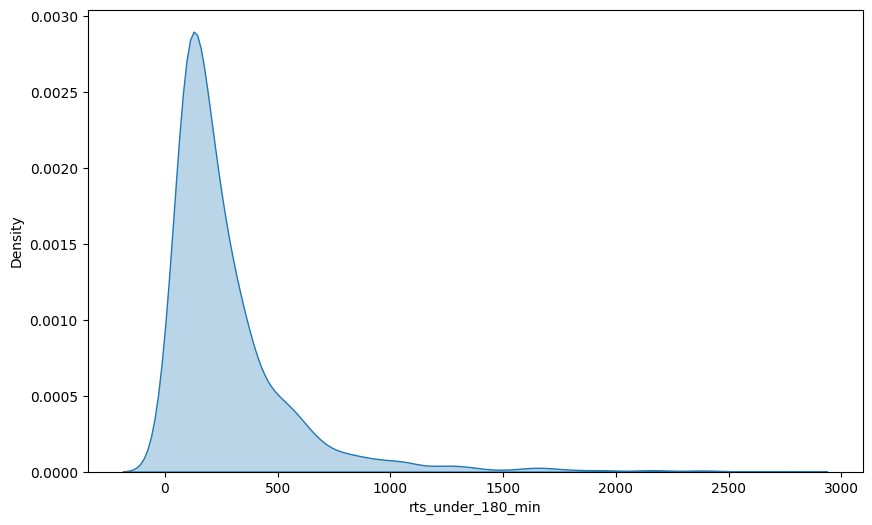

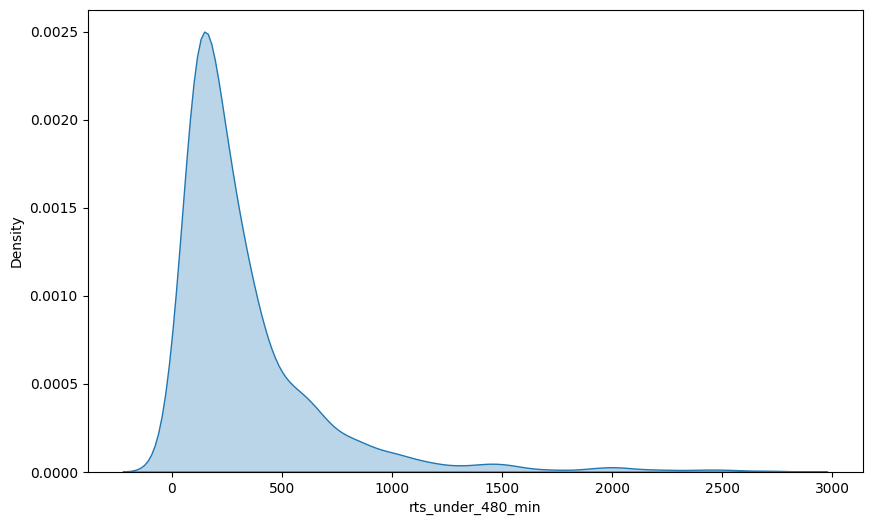

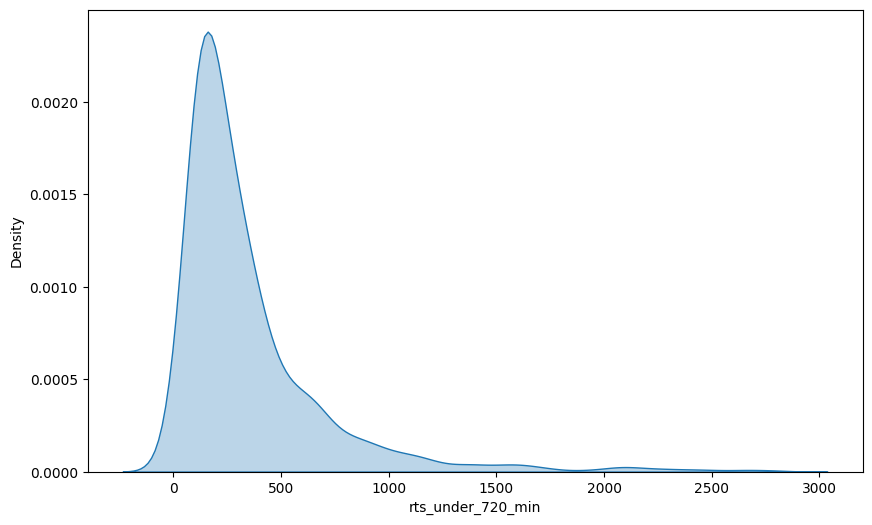

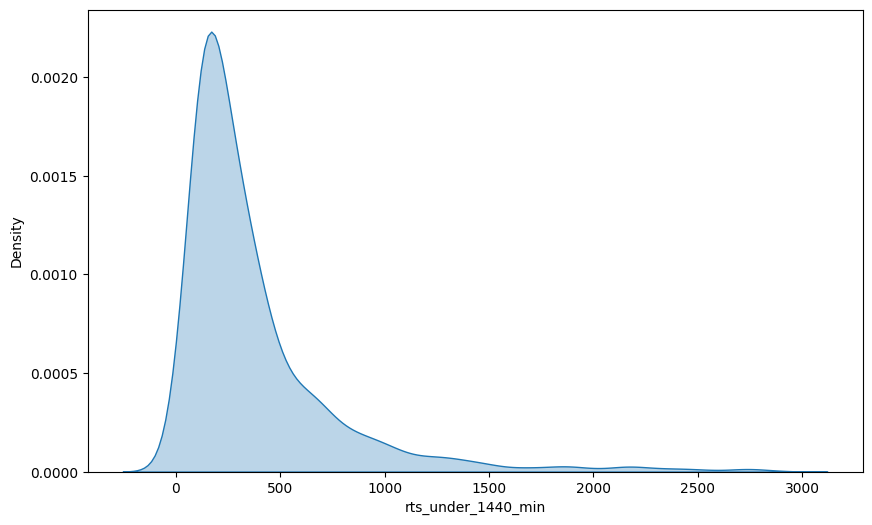

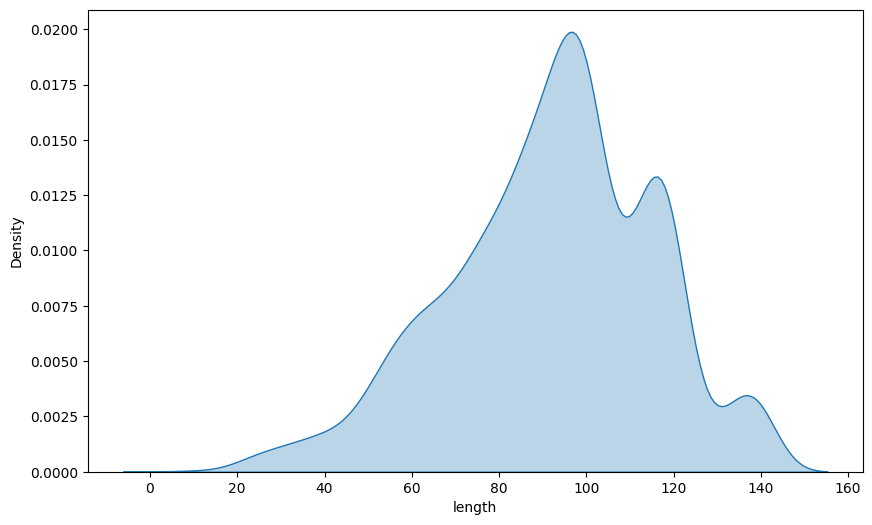

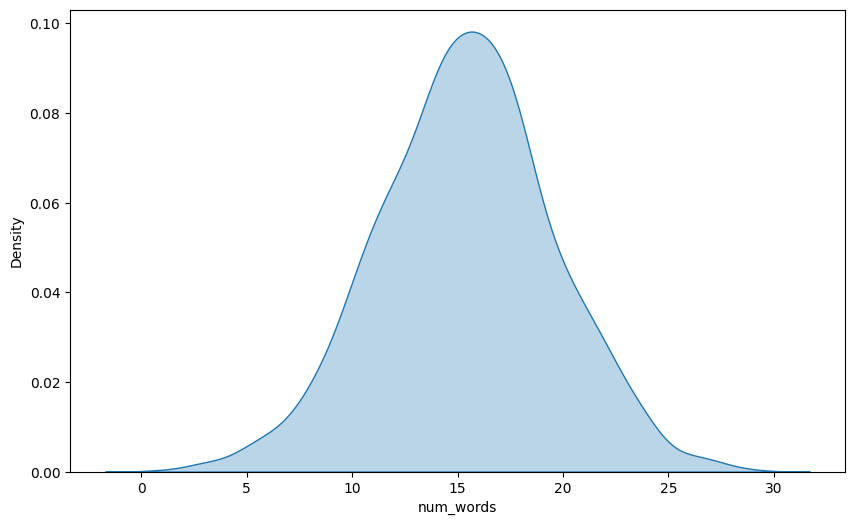

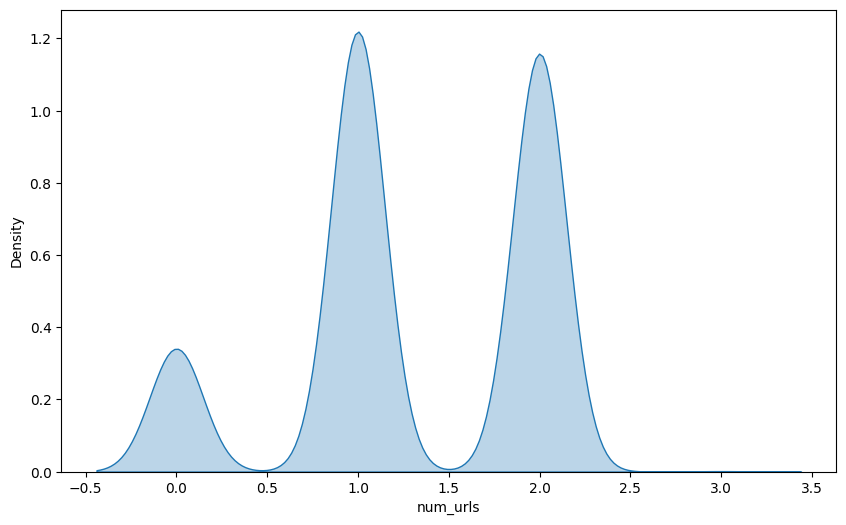

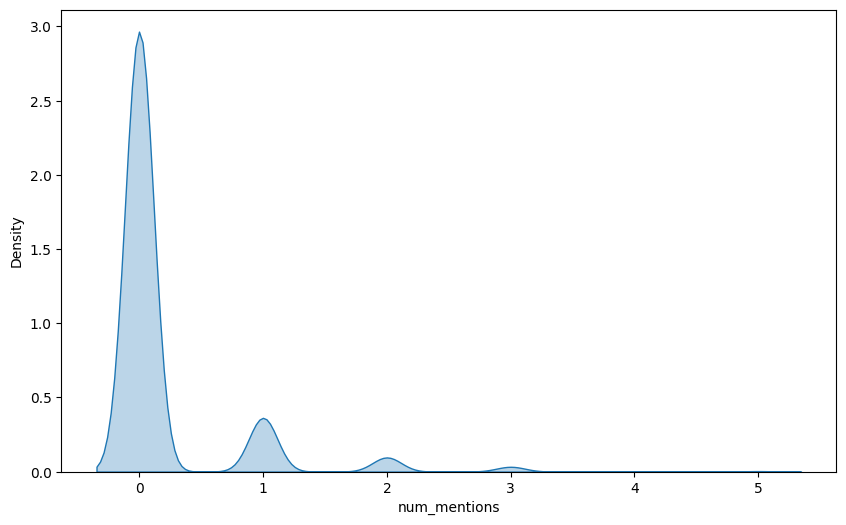

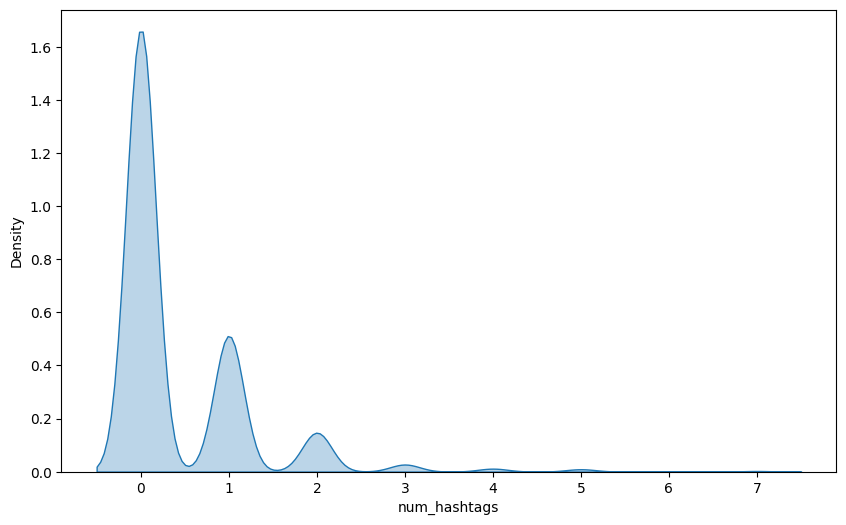

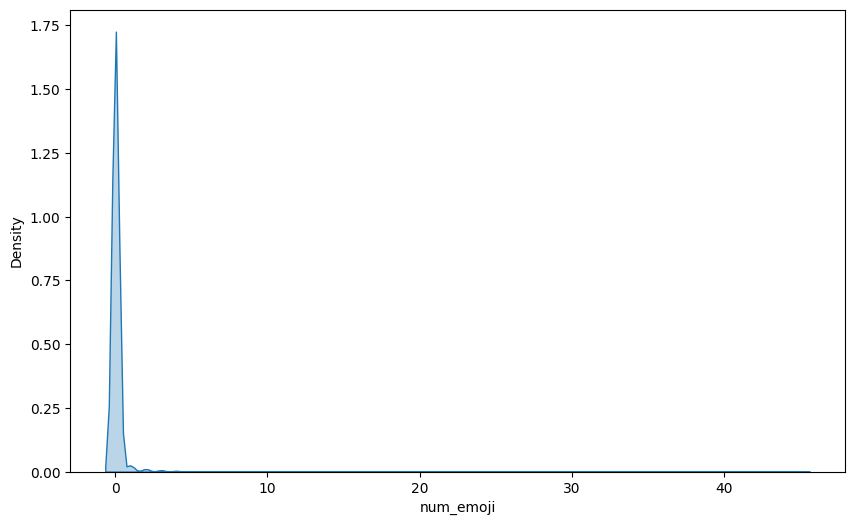

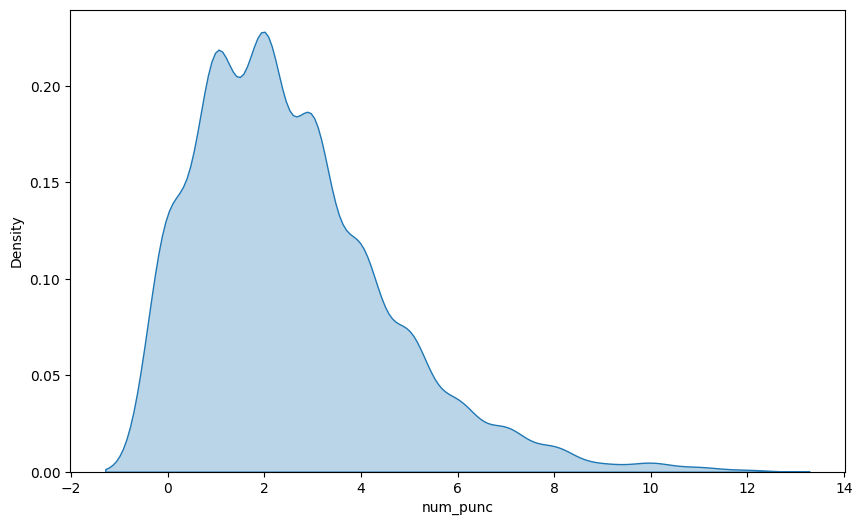

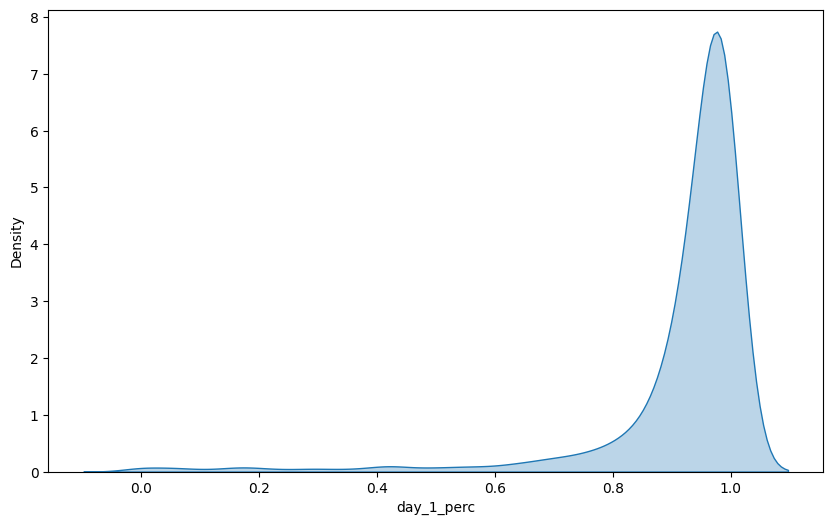

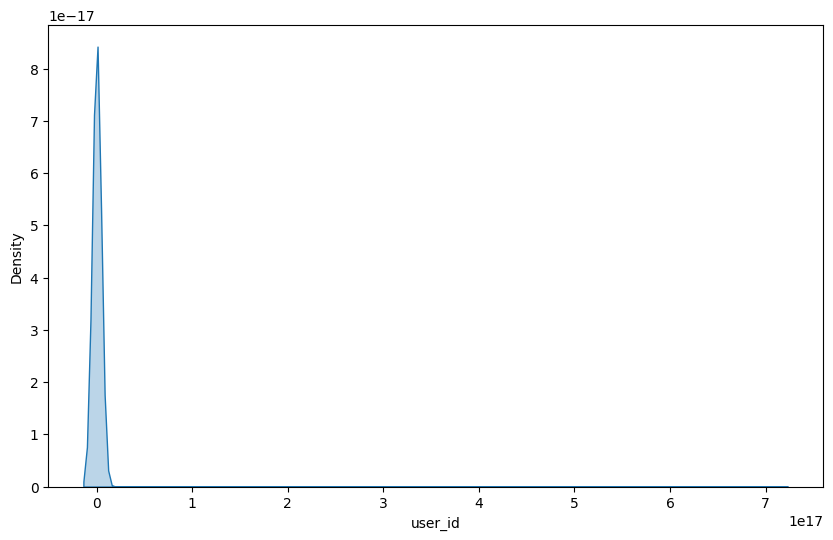

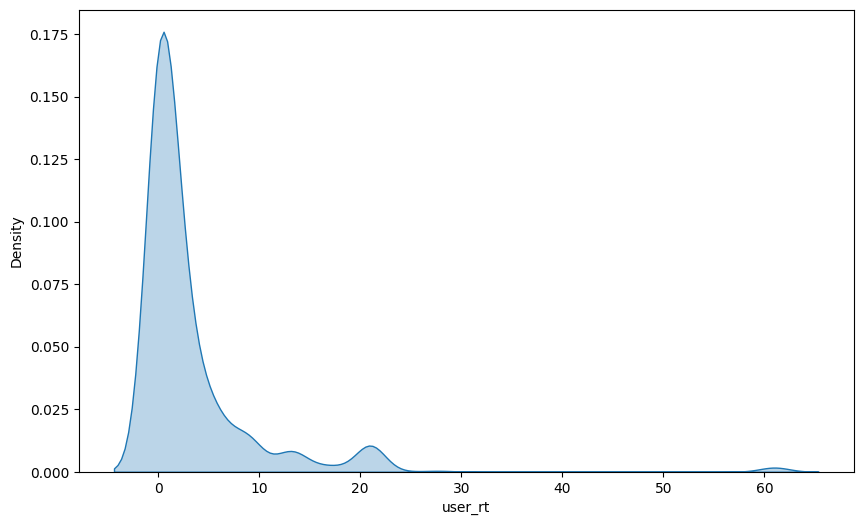

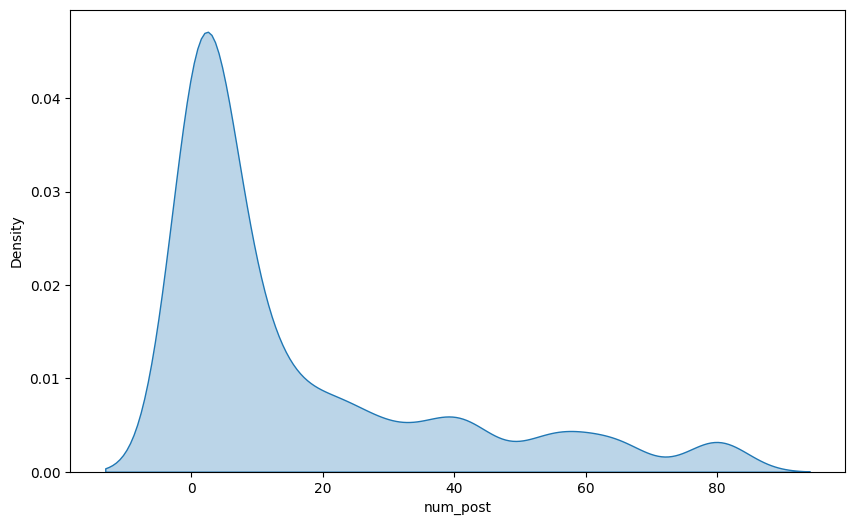

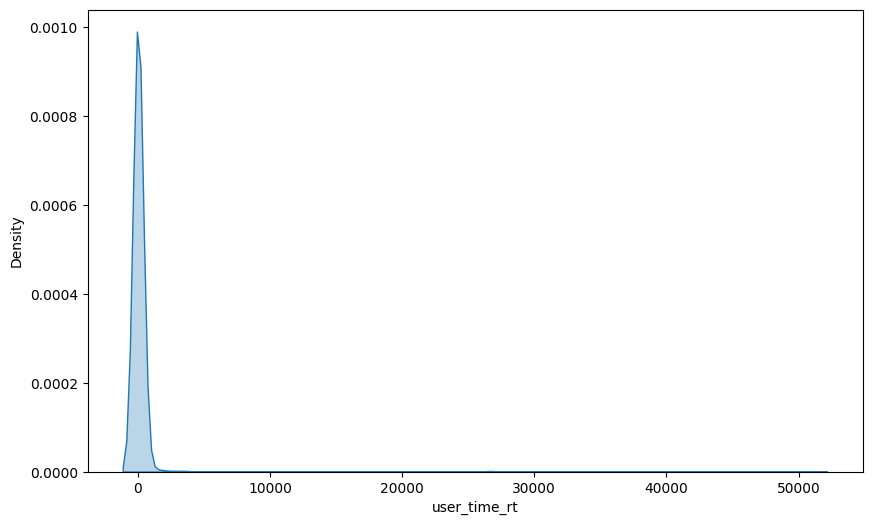

In [14]:
# distributions
def plot_dist(df, column):
  plt.figure(figsize=(10, 6))
  sns.kdeplot(df[column], fill=True, alpha=0.3)

  return None


def plot_dists(df):
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)
    
    for c in df_filtered.columns:
        plot_dist(df, c)

    return None

plot_dists(df)

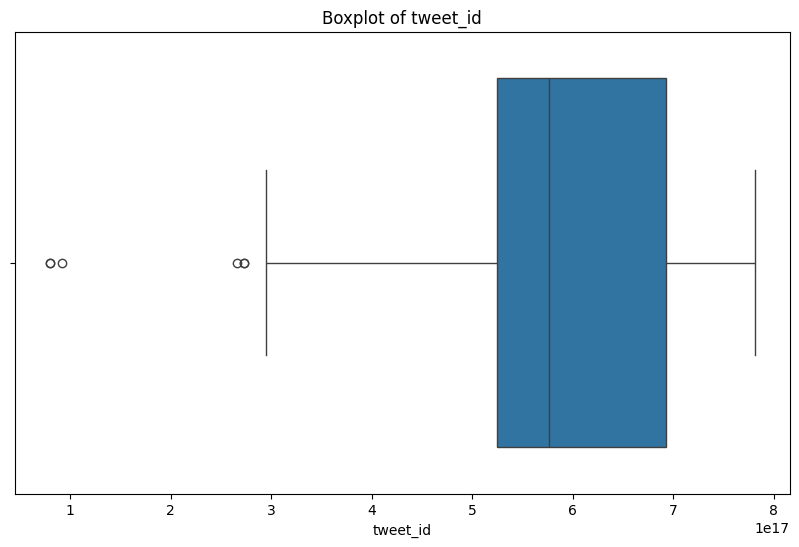

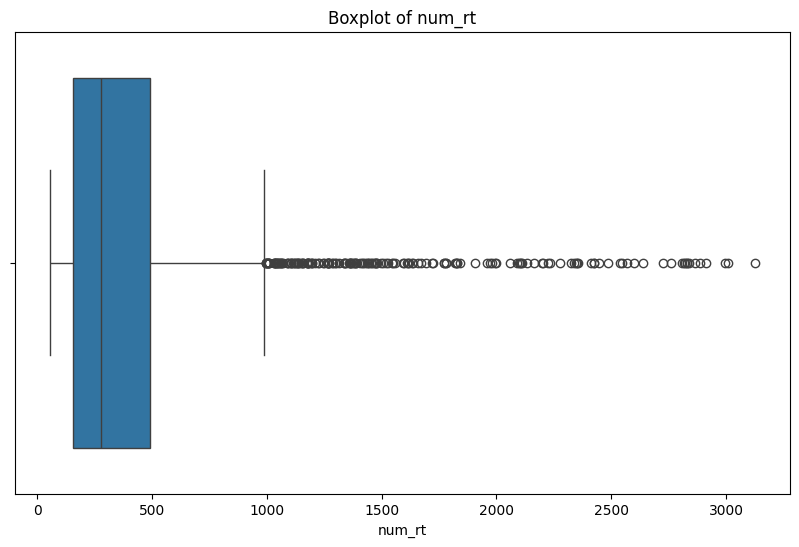

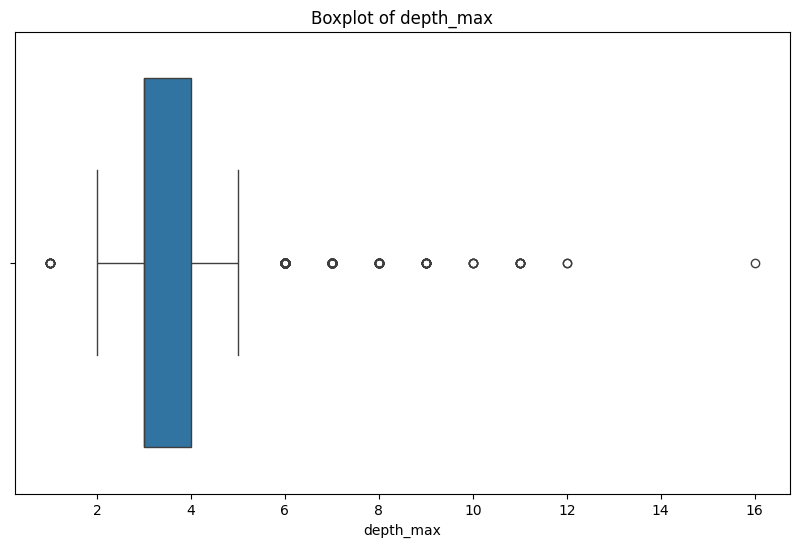

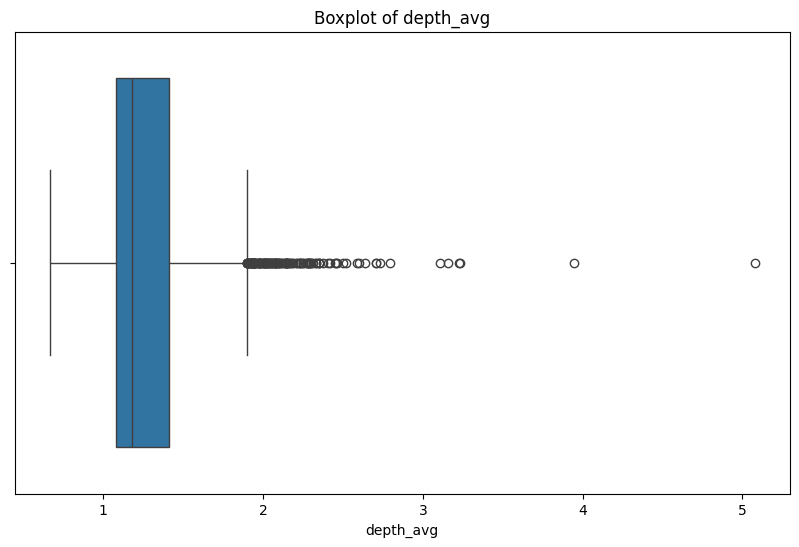

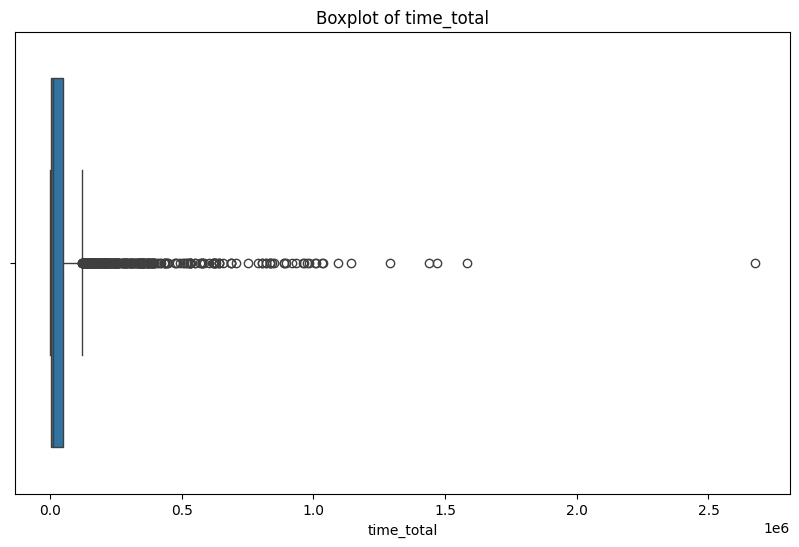

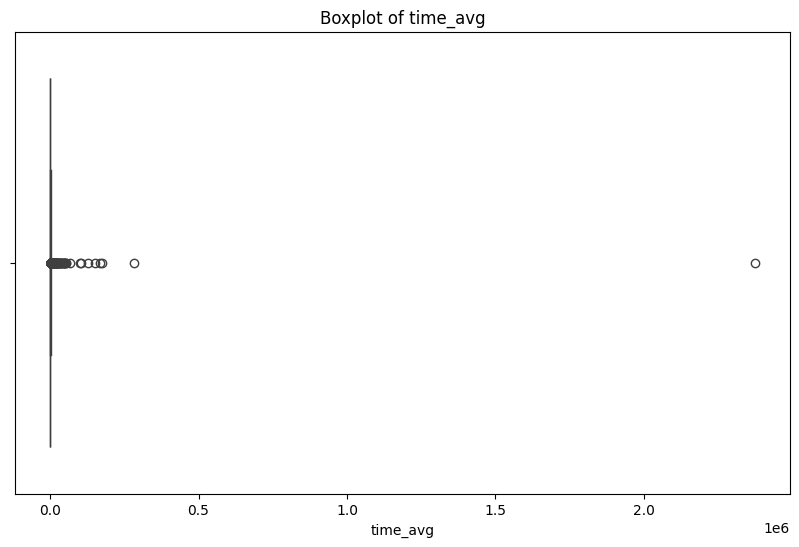

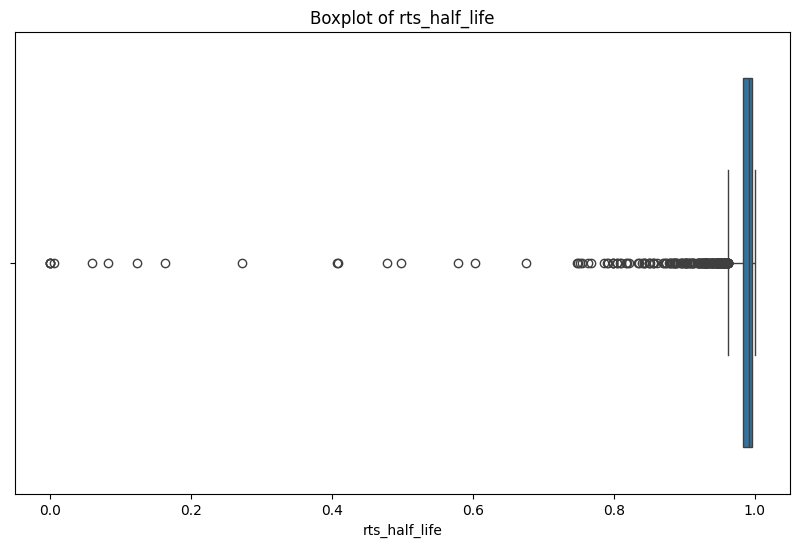

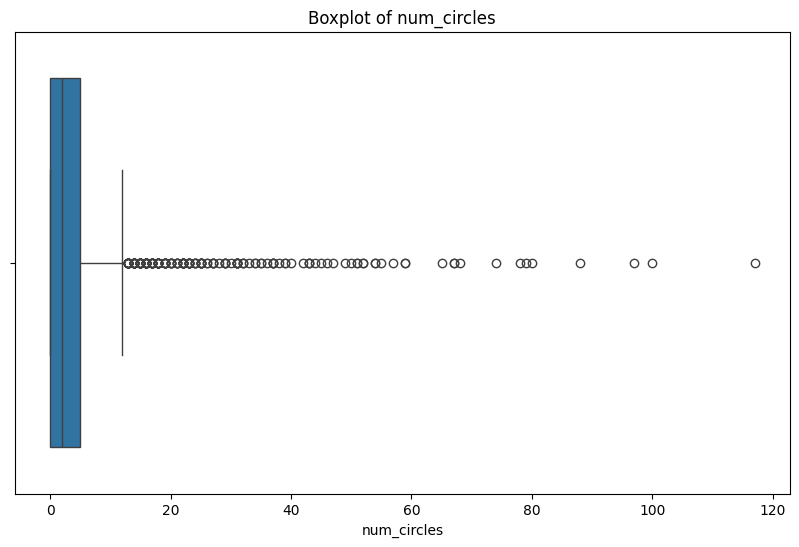

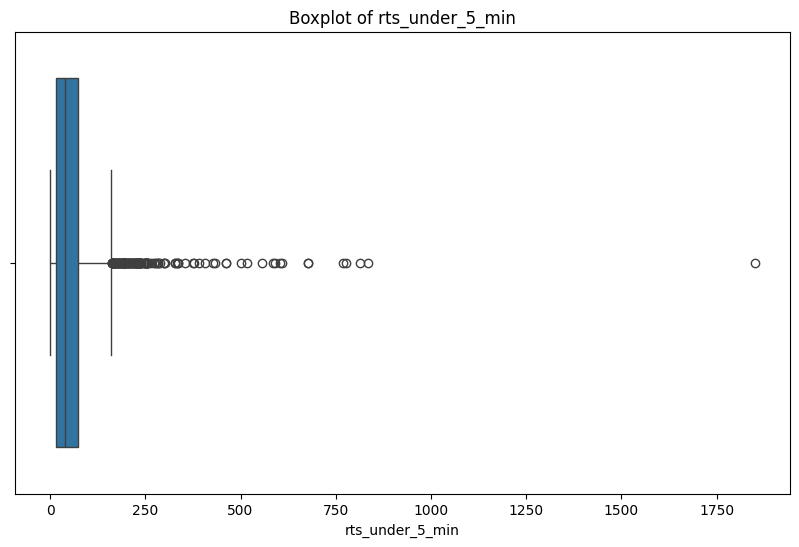

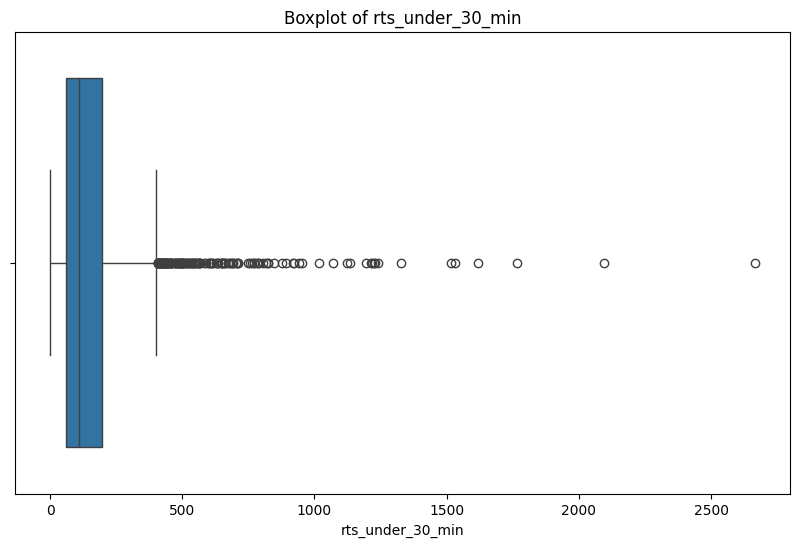

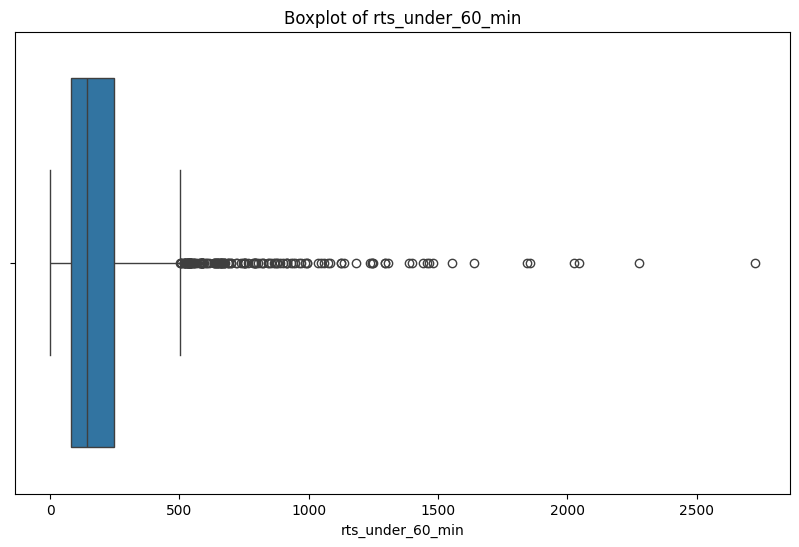

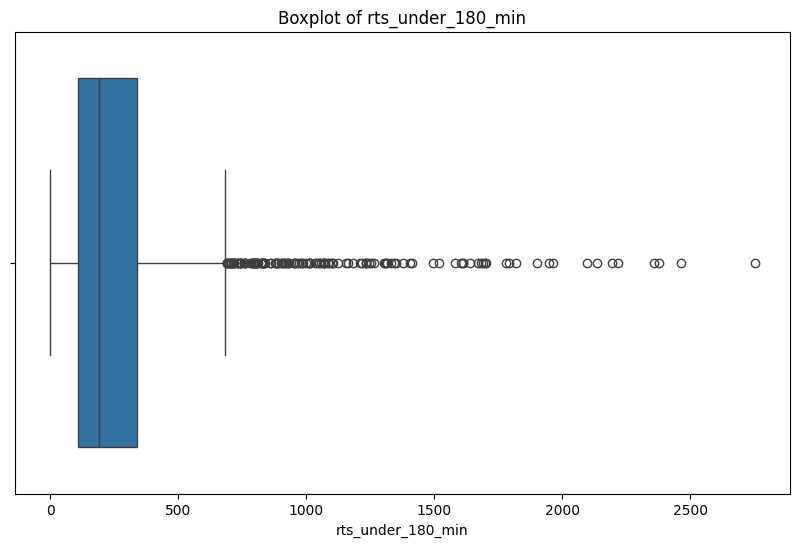

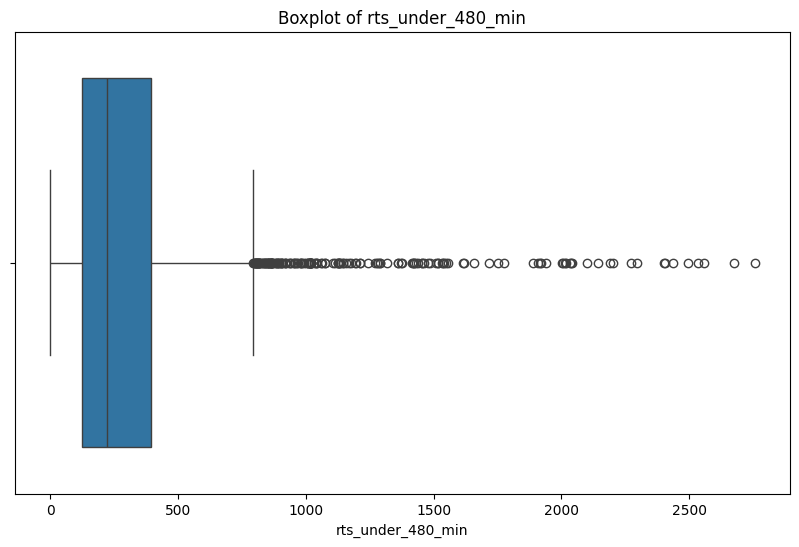

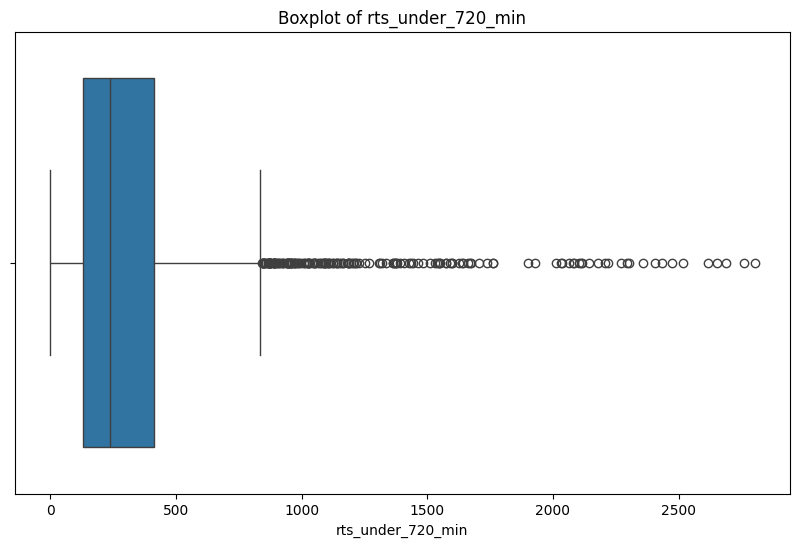

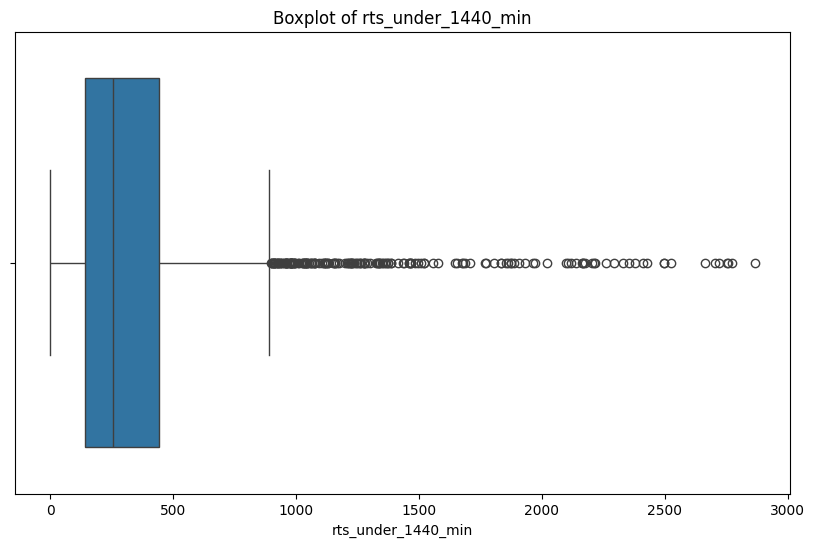

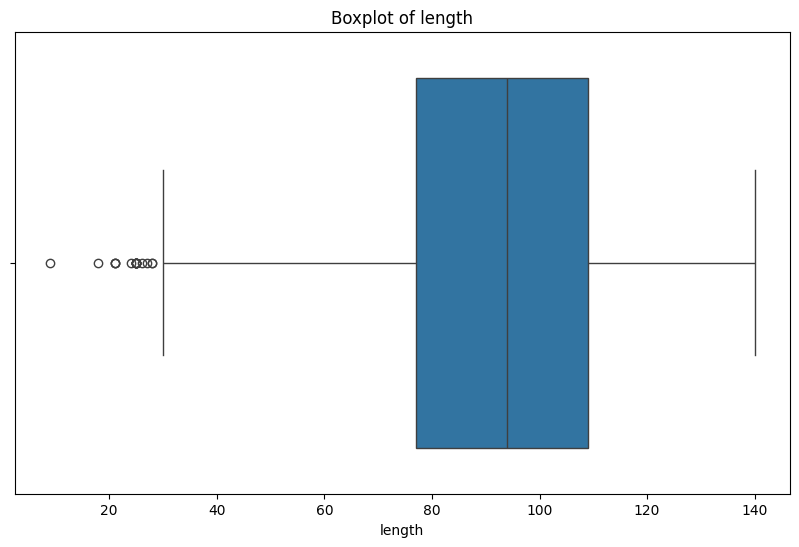

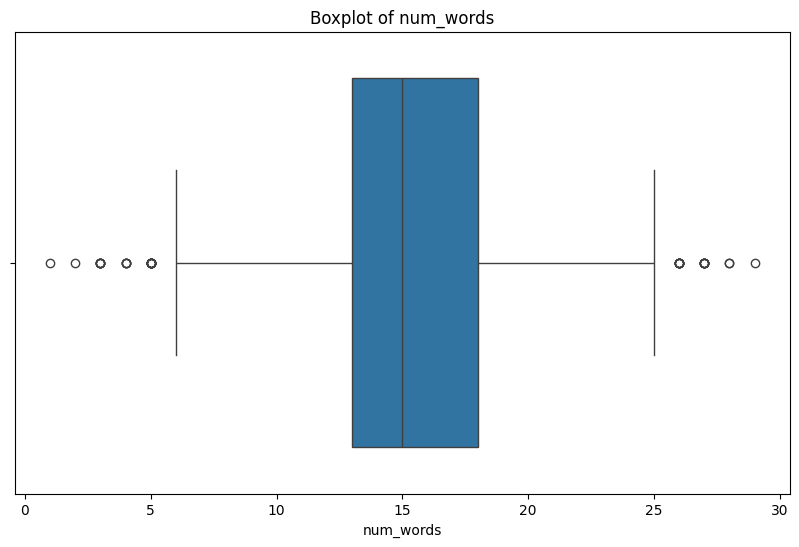

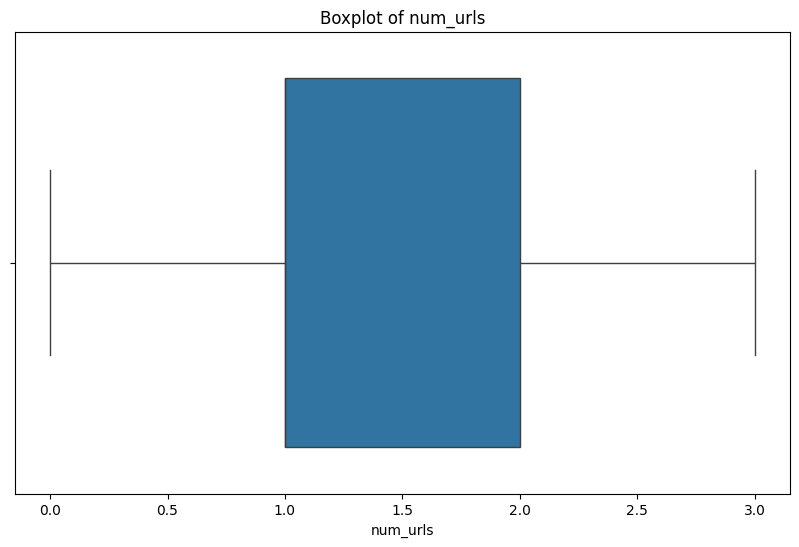

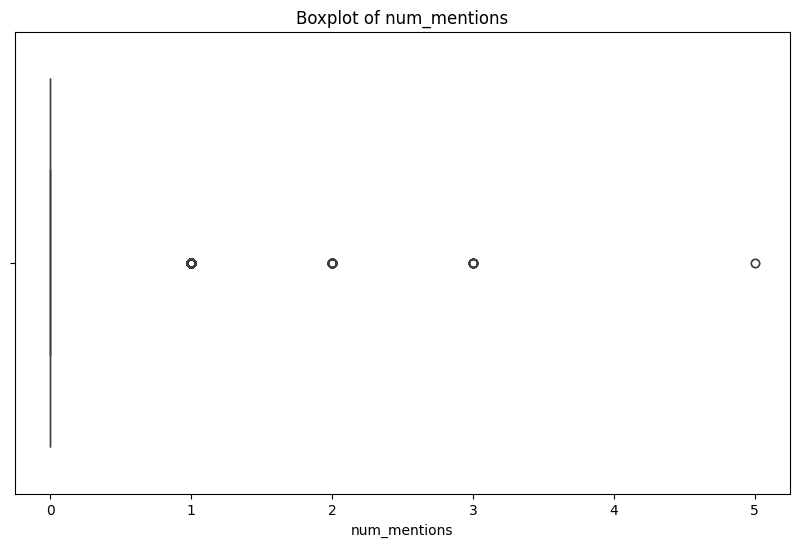

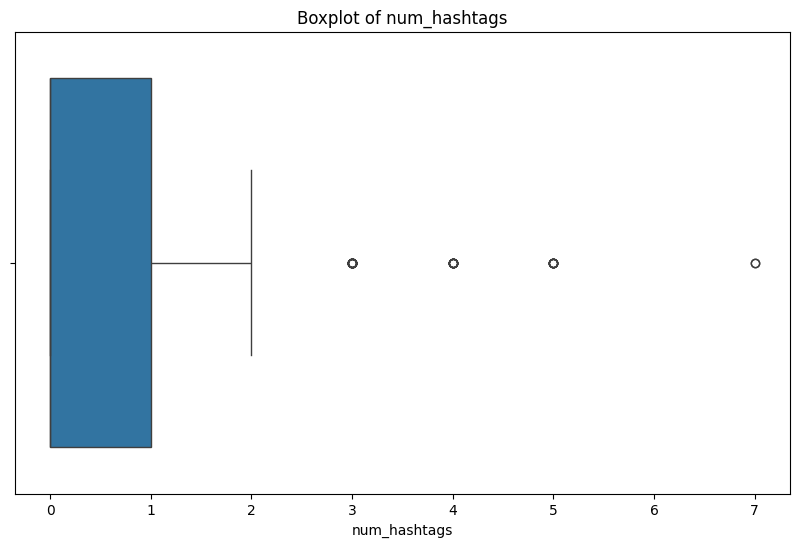

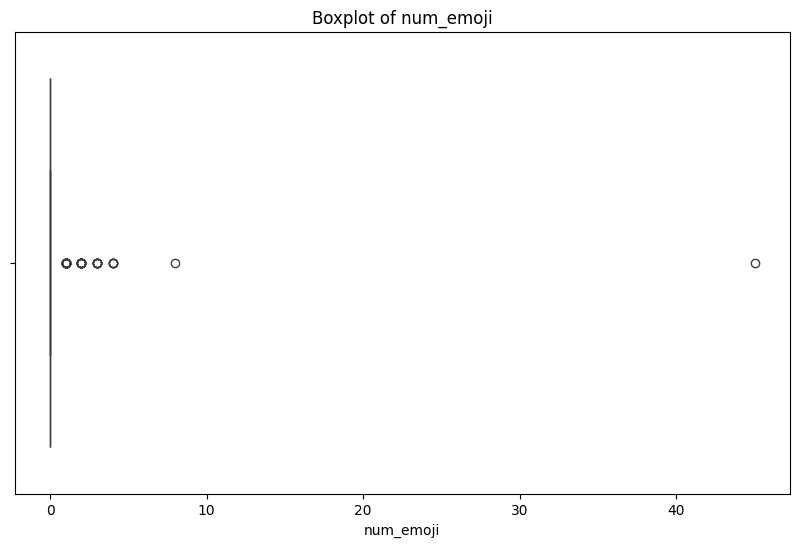

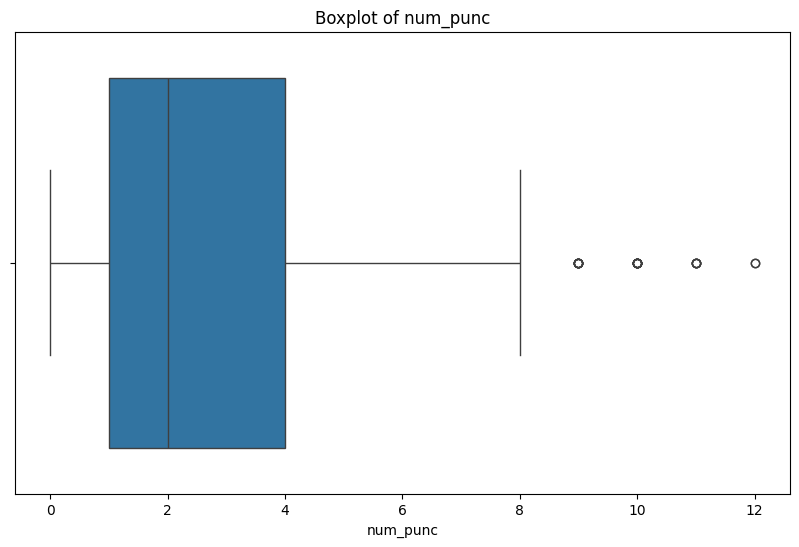

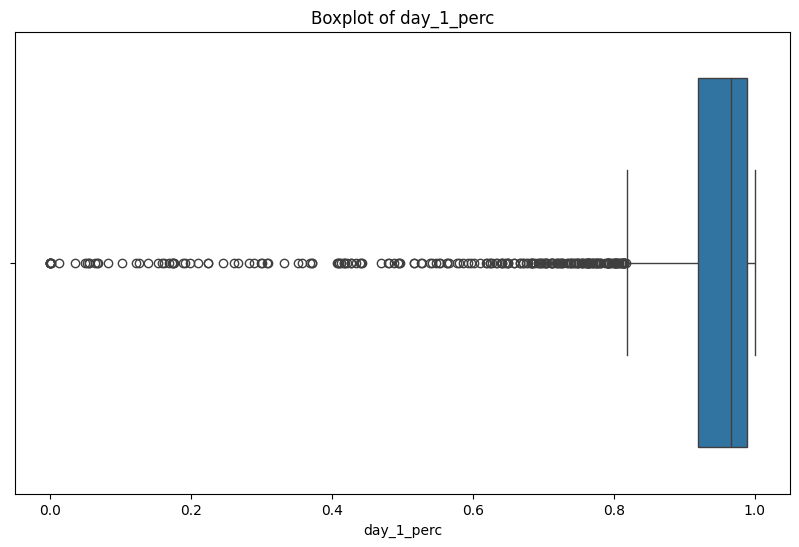

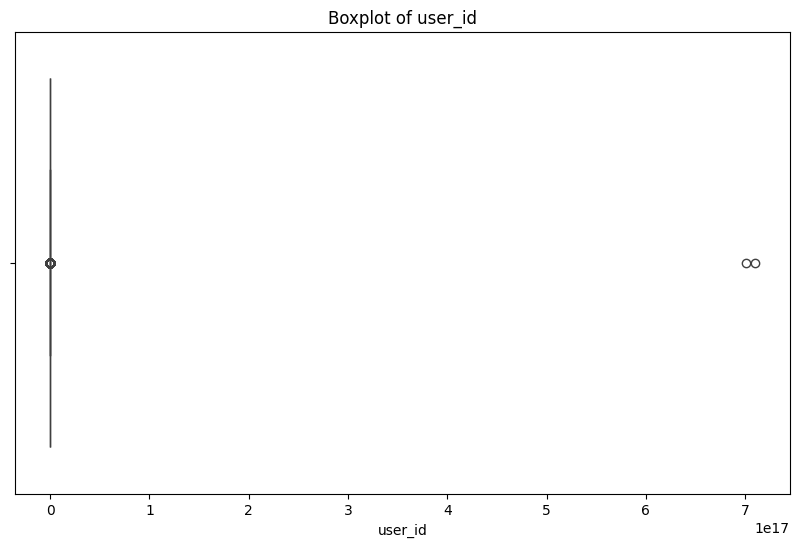

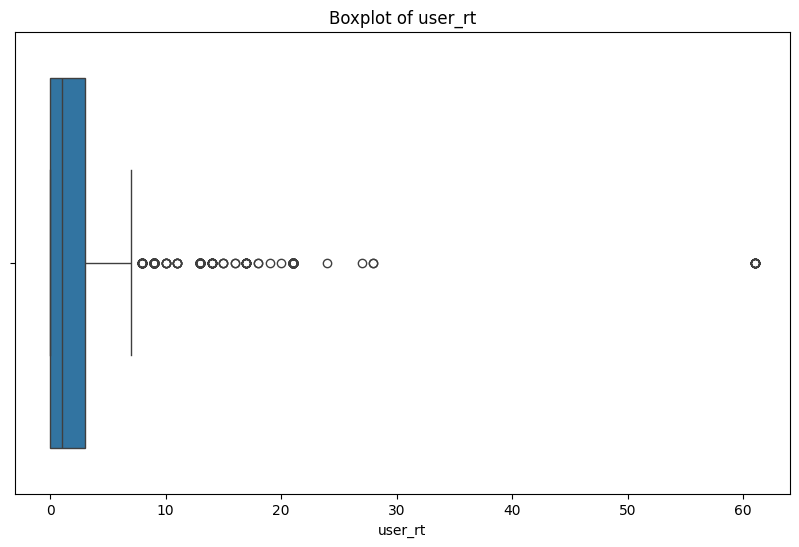

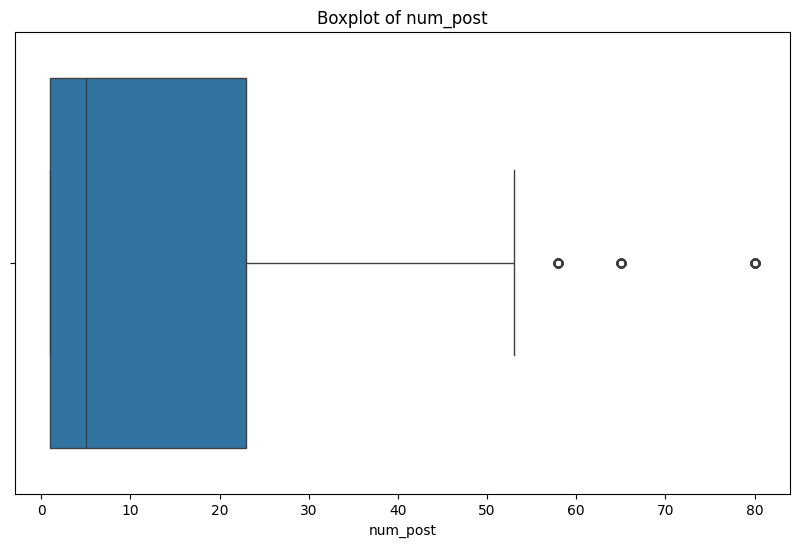

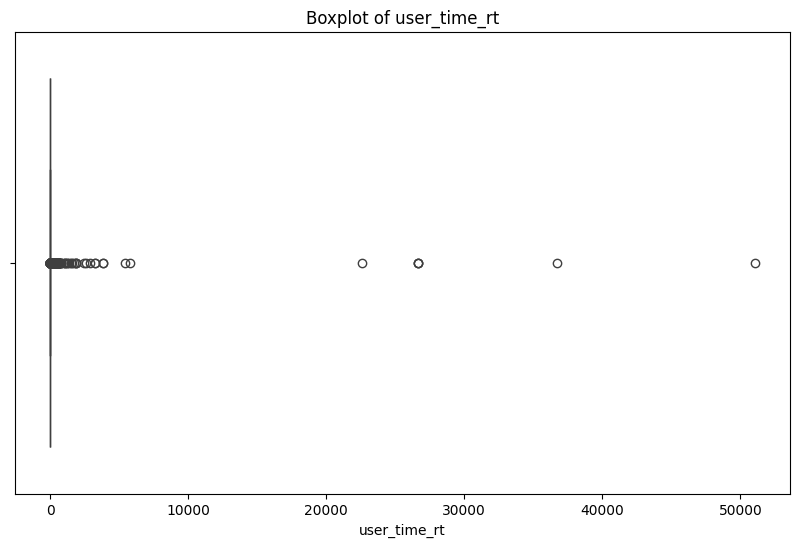

In [15]:
# box plots
def boxplot(df, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot of {column}")
    plt.show()
    
    return None


def boxplots(df):        
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)
    
    for c in df_filtered.columns:
        boxplot(df, c)

    return None

boxplots(df)

In [16]:
# skewness
def calc_skewness(df):
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)
    
    skewness = df_filtered.skew()
    skewness = skewness.sort_values(ascending=False)
    
    table = PrettyTable()
    table.field_names = ["Feature", "Skewness"]
    for c, skew in skewness.items():
        table.add_row([c, round(skew, 4)])

    print(table)

    return skewness
    
skewness = calc_skewness(df)

+--------------------+----------+
|      Feature       | Skewness |
+--------------------+----------+
|      time_avg      | 43.6034  |
|     num_emoji      | 38.7978  |
|      user_id       | 32.6822  |
|    user_time_rt    | 20.8427  |
|  rts_under_5_min   |  7.4505  |
|     time_total     |  5.3995  |
|    num_circles     |  5.0305  |
|      user_rt       |  4.7234  |
|  rts_under_30_min  |  4.4382  |
|  rts_under_60_min  |  3.8283  |
|    num_mentions    |  3.4286  |
| rts_under_180_min  |  3.2425  |
| rts_under_480_min  |  3.0053  |
| rts_under_720_min  |  2.9547  |
|       num_rt       |  2.8717  |
| rts_under_1440_min |  2.848   |
|    num_hashtags    |  2.7132  |
|     depth_avg      |  2.5952  |
|     depth_max      |  1.5726  |
|      num_post      |  1.5301  |
|      num_punc      |  1.1162  |
|     num_words      |  -0.042  |
|       length       | -0.3624  |
|      tweet_id      | -0.3966  |
|      num_urls      | -0.4495  |
|     day_1_perc     | -3.8239  |
|   rts_half_l

Removed highly correlated: rts_under_30_min
Removed highly correlated: rts_under_60_min
Removed highly correlated: rts_under_180_min
Removed highly correlated: rts_under_480_min
Removed highly correlated: rts_under_720_min
Removed highly correlated: rts_under_1440_min


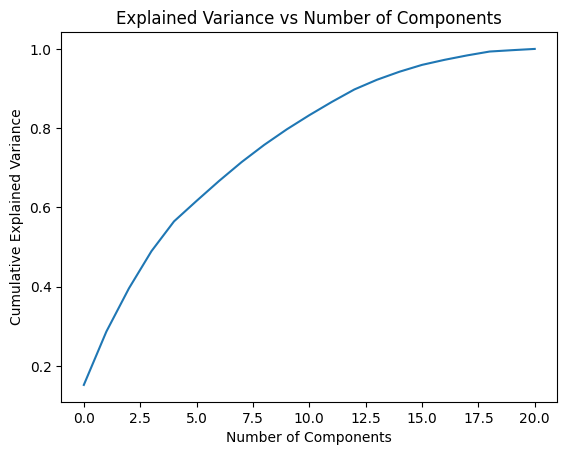

In [17]:
# PCA
def plot_pca(df):
    df_filtered = df.drop(columns=EXCLUDE_COLUMNS)

    df_filtered = remove_corr(df_filtered)
    df_filtered = log_transform(df_filtered)
    df_filtered = StandardScaler().fit_transform(df_filtered)
    
    pca = PCA().fit(df_filtered)
    
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs Number of Components')
    plt.show()

    return None

plot_pca(df)

In [18]:
# just true-false
df_true_false = df[(df['label'] == 0) | (df['label'] == 2)].copy()
df_true_false['label'] = df_true_false['label'].replace(2, 1)

df_true_false.to_csv(PATH + 'trueFalse.csv', index=False)

In [19]:
# just binary
# non-rumor  -> true
# unverified -> false

df_bin = df.copy()
df_bin['label'] = df_bin['label'].replace(2, 1)
df_bin['label'] = df_bin['label'].replace(3, 0)

df_bin.to_csv(PATH + 'binary.csv', index=False)

In [20]:
# all labels
df.to_csv(PATH + 'dataset.csv', index=False)

In [21]:
# reset
# df = df_og.copy()
# df = df.drop(columns = ['num_all_caps'])